# No ejecutar

In [ ]:
pip install scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [ ]:
df = pd.read_csv('DF_FINAL.csv')

In [ ]:
df1 = pd.read_csv('mi_dataset.csv')

In [ ]:
gen = pd.read_csv('generacion_p48_final.csv')

In [ ]:
# ---- 0) Si df o df1 vienen de un filtrado, copia primero
df  = df.copy()
df1 = df1.copy()             # <— importante

# 1) Renombrar clave y seguir con copia
df1 = df1.rename(columns={'fecha': 'date'}).copy()
df1 = df1.rename(columns={'hora': 'hour'}).copy()

# 2) Conversión de tipos usando .loc
df.loc[:,  'date'] = pd.to_datetime(df['date'])
df1.loc[:, 'date'] = pd.to_datetime(df1['date'])

df.loc[:,  'hour'] = df['hour'].astype(int)
df1.loc[:, 'hour'] = df1['hour'].astype(int)

# 3) Columnas nuevas
cols_nuevas = ['PVPC']

# 4) Merge left
df = df.merge(
    df1[['date', 'hour'] + cols_nuevas],
    on=['date', 'hour'],
    how='left'
)

In [ ]:
# Copias seguras
df = df.copy()
gen = gen.copy()

# Renombrar claves en gen para que coincidan con df
gen = gen.rename(columns={'Fecha': 'date', 'Hora': 'hour'})

# Convertir tipos correctamente
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['hour'].astype(int)

gen['date'] = pd.to_datetime(gen['date'])
gen['hour'] = gen['hour'].astype(int)

cols_nuevas = ['SPOT_ESP', 'SPOT_FR', 'SPOT_POR', 'tmed_diaria',
               'pmed_diaria', 'GenCO2', 'Demanda', 'PrecioGas', 'PVPC']

df = gen.merge(
    df[['date', 'hour'] + cols_nuevas],
    on=['date', 'hour'],
    how='left'
)

In [ ]:
df.to_csv('df.csv', index=False)

In [ ]:
from google.colab import files
files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
columnas = {
    'Hidraulica'        : 'Hidráulica',
    'HidraulicaNoUGH'   : 'Hidráulica - No UGH',
    'TurbinaBombeo'     : 'Turbina de Bombeo',
    'Nuclear'           : 'Nuclear',
    'CicloCombinado'    : 'Ciclo Combinado',
    'Fuel'              : 'Fuel',
    'GasNatural'        : 'Gas Natural',
    'SolarFotov'        : 'Solar Fotovoltaica',
    'SolarTer'          : 'Solar Térmica',
    'OceanGeoter'       : 'Oceánica + Geotérmica',
    'Biomasa'           : 'Biomasa',
    'ConsBombeo'        : 'Consumo de Bombeo',
    'Carbon'            : 'Carbón',
    'Fuel+Gas'          : 'Fuel + Gas',
    'Eolica'            : 'Eólica',
    'Cogeneracion'      : 'Cogeneración',
    'ResidNoRenov'      : 'Residuos No Renovables',
    'OtrasRenov'        : 'Otras Renovables',
    'GenCO2'            : 'Generación CO₂',
    'Demanda'           : 'Demanda Eléctrica',
    'SPOT_ESP'          : 'Spot España',
    'SPOT_FR'           : 'Spot Francia',
    'SPOT_POR'          : 'Spot Portugal',
    'PrecioGas'         : 'Precio Gas',
    'tmed_diaria'       : 'Temperatura Media',
    'pmed_diaria'       :'Precipitación Media',
    'GEN_NORENOV'      	: 'Generacion_renovables',
    'GEN_RENOV'         : 'Generacion_no_renovables',
 }

In [ ]:
def pretty_name(col):
    return columnas.get(col, col)

#TFG

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('TFG_DATOS.csv')

#Crear nuevas variables

La columna fecha se encuentra según el formato aaaa-mm-dd, queremos una nueva columna donde se distingan los días de la semana:

  0 - lunes
  1 - martes
  2- miércoles
  3 - jueves
  4 - viernes
  5 - sábado
  6 - domingo

Además, otra columna que distinga fin de semana:

  0 - Día laboral
  1 - Fin de semana

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Asegurar formato
df['date'] = pd.to_datetime(df['date'])
df['DiaSemana'] = df['date'].dt.dayofweek


festivos_nacionales = [
    (1, 1),    # Año Nuevo
    (6, 1),    # Reyes
    (1, 5),    # Día del Trabajador
    (15, 8),   # Asunción
    (12, 10),  # Fiesta Nacional
    (1, 11),   # Todos los Santos
    (6, 12),   # Constitución
    (8, 12),   # Inmaculada
    (25, 12)   # Navidad
]

# Codificar directamente
def codificar_tipo_dia(row):
    if (row['date'].day, row['date'].month) in festivos_nacionales:
        return 2  # Festivo
    elif row['DiaSemana'] >= 5:
        return 1  # Fin de semana
    else:
        return 0  # Laboral

df['TipoDia'] = df.apply(codificar_tipo_dia, axis=1)

Ahora vamos a diferenciar las horas del día:

  0 - Entre las 7:00 y las 22:00
  1 - Entre las 23:00 y las 6:00

In [5]:
df['HoraDia'] = pd.to_numeric(df['hour'], errors='coerce').astype(int)

# Marca como hora de trabajo (1) todo entre las 8 y las 18 (excluida), resto 0
df['HoraTrabajo'] = df['HoraDia'].apply(lambda x: 1 if 8 <= x <= 18 else 0)

Por últimos vamos a crear dos columnas diferenciando los años y los meses

In [6]:
df['Año'] = df['date'].dt.year
df['Mes'] = df['date'].dt.month

Vamos a diferenciarnos por estaciones también

In [7]:
def obtener_estacion_fecha(date):
    año = date.year
    primavera = pd.Timestamp(f"{año}-03-21")
    verano     = pd.Timestamp(f"{año}-06-21")
    otoño      = pd.Timestamp(f"{año}-09-23")
    invierno   = pd.Timestamp(f"{año}-12-21")

    if date >= invierno or date < primavera:
        return 0  # Invierno
    elif primavera <= date < verano:
        return 1  # Primavera
    elif verano <= date < otoño:
        return 2  # Verano
    else:
        return 3  # Otoño

df['Estacion'] = df['date'].apply(obtener_estacion_fecha)

#Minería de datos

## Valores nulos

Primero vamos a ver que hacemos con los valores nulos o faltantes, lo observamos por columnas.

In [8]:
df.columns

Index(['date', 'hour', 'Residuos domésticos', 'Turbinación bombeo',
       'Residuos no renovables', 'Exportación Andorra', 'Nuclear', 'Genéricas',
       'Solar fotovoltaica', 'Hidráulica', 'Generación + Bombeo + Cable',
       'Exportación Marruecos', 'Exportación Francia',
       'Gas Natural Cogeneración', 'Saldo Francia', 'Importación Portugal',
       'Cogeneración', 'Saldo interconexiones', 'Hidráulica no UGH',
       'Saldo Marruecos', 'Generación P48 total', 'Ciclo combinado', 'Biomasa',
       'Exportación Portugal', 'Exportación Total',
       'Generación + Interconexiones', 'Importación Francia', 'Saldo Andorra',
       'Biogás', 'Solar térmica', 'Importación Total', 'Subproductos minería',
       'Enlace Baleares', 'Fuel', 'Derivados petróleo o carbón', 'Carbón',
       'Hidráulica UGH', 'Fuel-Gas', 'Importación Marruecos', 'Consumo bombeo',
       'Hulla sub-bituminosa', 'Hulla antracita', 'Saldo Portugal',
       'Demanda Peninsular', 'Océano y geotérmica', 'Residuos var

In [9]:
columnas = {
    'date': 'Fecha',
    'hour': 'Hora',
    'Residuos domésticos': 'Residuos domésticos',
    'Turbinación bombeo': 'Turbinación por bombeo',
    'Residuos no renovables': 'Residuos no renovables',
    'Exportación Andorra': 'Exportación a Andorra',
    'Nuclear': 'Generación nuclear',
    'Genéricas': 'Generación genérica',
    'Solar fotovoltaica': 'Solar fotovoltaica',
    'Hidráulica': 'Hidráulica total',
    'Generación + Bombeo + Cable': 'Generación + Bombeo + Cable',
    'Exportación Marruecos': 'Exportación a Marruecos',
    'Exportación Francia': 'Exportación a Francia',
    'Gas Natural Cogeneración': 'Cogeneración gas natural',
    'Saldo Francia': 'Saldo con Francia',
    'Importación Portugal': 'Importación desde Portugal',
    'Cogeneración': 'Cogeneración',
    'Saldo interconexiones': 'Saldo interconexiones',
    'Hidráulica no UGH': 'Hidráulica no UGH',
    'Saldo Marruecos': 'Saldo con Marruecos',
    'Generación P48 total': 'Generación total (P48)',
    'Ciclo combinado': 'Ciclo combinado',
    'Biomasa': 'Biomasa',
    'Exportación Portugal': 'Exportación a Portugal',
    'Exportación Total': 'Exportación total',
    'Generación + Interconexiones': 'Generación + Interconexiones',
    'Importación Francia': 'Importación desde Francia',
    'Saldo Andorra': 'Saldo con Andorra',
    'Biogás': 'Biogás',
    'Solar térmica': 'Solar térmica',
    'Importación Total': 'Importación total',
    'Subproductos minería': 'Subproductos de minería',
    'Enlace Baleares': 'Enlace con Baleares',
    'Fuel': 'Fuel',
    'Derivados petróleo o carbón': 'Derivados petróleo/carbón',
    'Carbón': 'Carbón',
    'Hidráulica UGH': 'Hidráulica UGH',
    'Fuel-Gas': 'Fuel-Gas',
    'Importación Marruecos': 'Importación desde Marruecos',
    'Consumo bombeo': 'Consumo por bombeo',
    'Hulla sub-bituminosa': 'Hulla sub-bituminosa',
    'Hulla antracita': 'Hulla antracita',
    'Saldo Portugal': 'Saldo con Portugal',
    'Demanda Peninsular': 'Demanda peninsular',
    'Océano y geotérmica': 'Energía oceánica y geotérmica',
    'Residuos varios': 'Otros residuos',
    'Hibridación': 'Hibridación',
    'Total Almacenamiento': 'Almacenamiento total',
    'Energía residual': 'Energía residual',
    'Ajuste P48': 'Ajuste del programa P48',
    'Eólica terrestre': 'Eólica terrestre',
    'Otras renovables': 'Otras renovables',
    'Eólica': 'Eólica total',
    'SPOT_ESP': 'Precio SPOT España',
    'SPOT_FR': 'Precio SPOT Francia',
    'SPOT_POR': 'Precio SPOT Portugal',
    'tmed_diaria': 'Temperatura media diaria',
    'pmed_diaria': 'Presión media diaria',
    'GenCO2': 'Generación CO₂',
    'Demanda': 'Demanda',
    'PrecioGas': 'Precio del gas',
    'PVPC': 'Precio PVPC',
    'DiaSemana': 'Día de la semana',
    'TipoDia': 'Tipo de día',
    'Fecha': 'Fecha (extraída)',
    'HoraDia': 'Hora del día',
    'HoraTrabajo': 'Hora laboral',
    'Año': 'Año',
    'Mes': 'Mes',
    'Estación': 'Estación'
}

<ipython-input-10-6278f12d9662>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


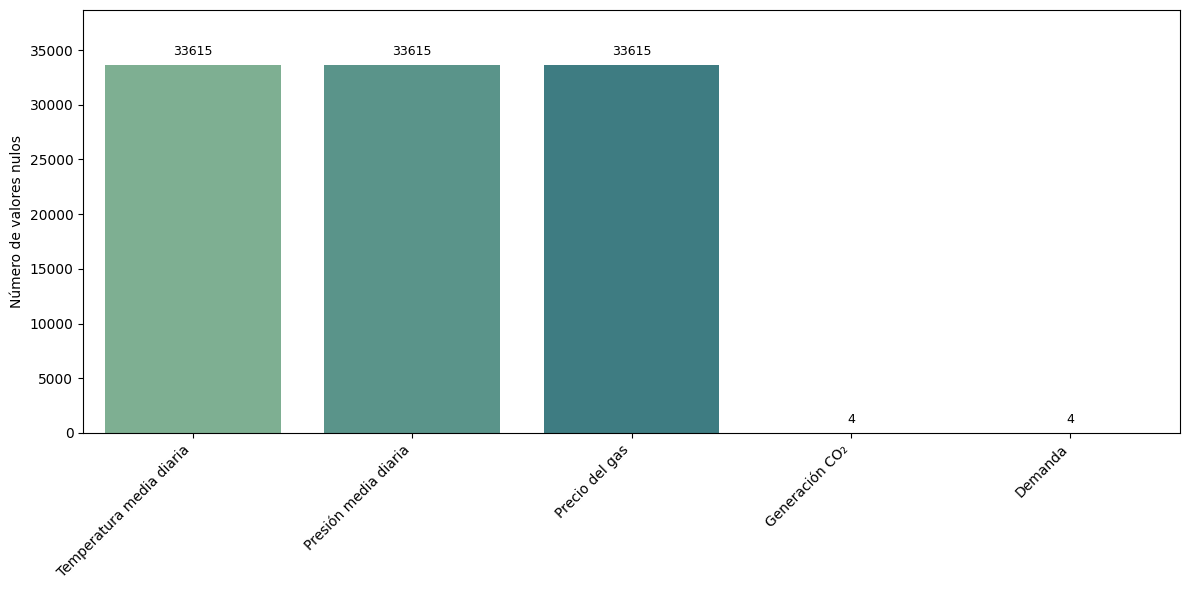

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

null_counts = df.isna().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)

if null_counts.empty:
    print("No hay nulos")
else:
    cols   = null_counts.index.tolist()
    counts = null_counts.values
    pretty = [columnas.get(c, c) for c in cols]

    plt.figure(figsize=(max(12, len(cols)*0.5), 6))  # ancho dinámico
    sns.barplot(
        x=cols,
        y=counts,
        palette=sns.color_palette("crest", len(cols))
    )

    for x, y in enumerate(counts):
        plt.text(x, y + max(counts)*0.02, str(int(y)), ha='center', va='bottom', fontsize=9)

    plt.ylim(0, max(counts) * 1.15)  # altura adaptada
    plt.xticks(ticks=range(len(cols)), labels=pretty, rotation=45, ha='right')
    plt.ylabel("Número de valores nulos")
    plt.title("")
    plt.tight_layout()
    plt.show()

In [11]:
print(df.isnull().sum())

date                      0
hour                      0
Residuos domésticos       0
Turbinación bombeo        0
Residuos no renovables    0
                         ..
HoraDia                   0
HoraTrabajo               0
Año                       0
Mes                       0
Estacion                  0
Length: 69, dtype: int64


In [12]:
col = ['GenCO2', 'Demanda']
filas_eolica_nulas = df[df['Demanda'].isna()]
filas_eolica_nulas[['date', 'hour'] + col]

date  hour  GenCO2  Demanda
2067  2021-03-28     2     NaN      NaN
10806 2022-03-27     2     NaN      NaN
19545 2023-03-26     2     NaN      NaN
28452 2024-03-31     2     NaN      NaN

De momento solo vamos a rellenar con la media de las filas de arriba.


In [13]:
i = [2067, 10806, 19545, 28452]

cols = ['GenCO2', 'Demanda']

for idx in i:
    idx_prev = idx - 1
    idx_next = idx + 1

    for col in cols:
        v_prev = df.at[idx_prev, col]
        v_next = df.at[idx_next, col]

        if not (pd.isna(v_prev) or pd.isna(v_next)):
            df.at[idx, col] = (v_prev + v_next) / 2.0

Vamos a volver a comprobar valores nulos.

In [14]:
df = df.drop('Demanda', axis=1)

In [15]:
print(df.isnull().sum())

date                      0
hour                      0
Residuos domésticos       0
Turbinación bombeo        0
Residuos no renovables    0
                         ..
HoraDia                   0
HoraTrabajo               0
Año                       0
Mes                       0
Estacion                  0
Length: 68, dtype: int64


Las variables de temperatura, precipitación y precio del gas tienen cantidades de valores nulos parecidas porque no se han encontrado datos durante cada hora. Entonces para la del gas vamos a rellenar con el mismo valor todo un día, ya que no conocemos las fluctuaciones del gas.

In [16]:
# Crear serie con un PrecioGas por día (solo uno por fecha)
precio_por_dia = df[df['PrecioGas'].notna()].groupby('date')['PrecioGas'].first()

# Crear rango completo de fechas en el dataset
fechas_completas = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Reindexar para incluir todos los días y rellenar con el valor más cercano
precio_por_dia = precio_por_dia.reindex(fechas_completas).sort_index()
precio_por_dia.index.name = 'date'
precio_por_dia = precio_por_dia.ffill().bfill()  # primero hacia adelante, luego hacia atrás

In [17]:
# Asegúrate de que la columna date esté en formato datetime.date
df['date'] = pd.to_datetime(df['date']).dt.date
precio_por_dia.index = precio_por_dia.index.date  # para que coincidan los tipos

# Mapear al dataframe original
df['PrecioGas'] = df['date'].map(precio_por_dia)

Para la temperatura

In [18]:
# Asegurarse de que las columnas están bien
df['date'] = pd.to_datetime(df['date']).dt.date
df['hour'] = df['hour'].astype(int)

# Crear perfil horario de variación: -1 ºC a +1 ºC
temp_profile = np.zeros(24)
for i, h in enumerate(range(6, 18)):  # subida 6h–17h
    temp_profile[h] = -1 + 2 * i / 11
for i, h in enumerate(list(range(18, 24)) + list(range(0, 6))):  # bajada 18h–5h
    temp_profile[h] = 1 - 2 * i / 11

# Crear un diccionario con la tmed_diaria de cada día (en hour == 0)
tmed_por_dia = df[df['hour'] == 0].set_index('date')['tmed_diaria'].to_dict()

# Rellenar tmed_hourly con el perfil por hora, según la tmed_diaria del día
def estimar_tmed(row):
    dia = row['date']
    hora = row['hour']
    if dia in tmed_por_dia:
        return tmed_por_dia[dia] + temp_profile[hora]
    else:
        return np.nan

df['tmed_hourly'] = df.apply(estimar_tmed, axis=1)

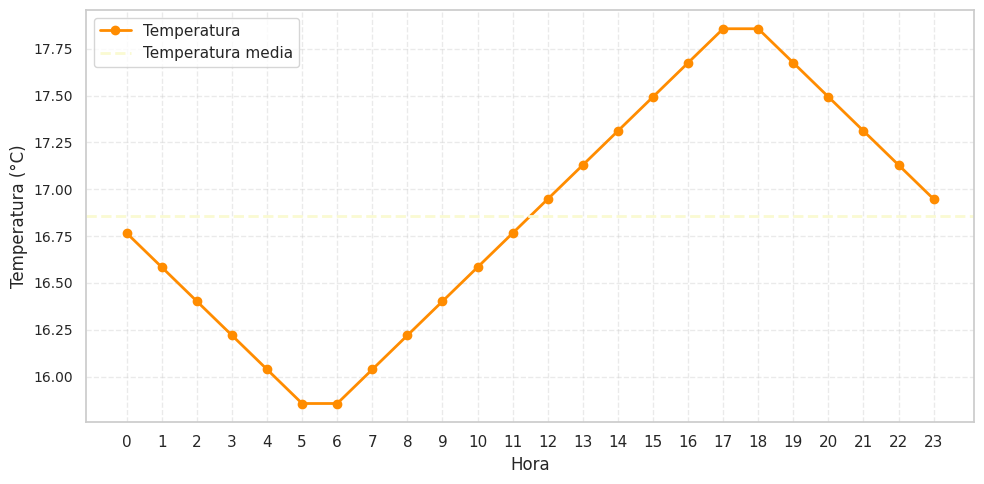

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo estético de seaborn
sns.set_theme(style="whitegrid")

# Seleccionar fecha con valores no nulos
fecha_ejemplo = df[df['tmed_hourly'].notna()]['date'].iloc[3483]
df_dia = df[df['date'] == fecha_ejemplo]

# Crear gráfico
plt.figure(figsize=(10, 5))
plt.plot(df_dia['hour'], df_dia['tmed_hourly'], marker='o', linewidth=2, color='#FF8C00', label='Temperatura')
plt.axhline(tmed_por_dia[fecha_ejemplo], color='#FAFAD2', linestyle='--', linewidth=2, label='Temperatura media')

# Añadir detalles estéticos
plt.title(f'', fontsize=14)
plt.xlabel('Hora', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(range(0, 24))
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("temperatura.png", dpi=300)
plt.show()

Para la precipitacion

In [20]:
def distribute_precipitation(df):
    # Create a copy to avoid modifying the original DataFrame
    df_new = df.copy()

    # Group by date and get the daily average precipitation
    daily_precip = df_new.groupby('date')['pmed_diaria'].mean()

    # Iterate over each date
    for date, precip in daily_precip.items():
        # Select rows for the current date
        rows_to_update = df_new[df_new['date'] == date].index

        # Distribute precipitation evenly across the hours (basic example)
        hourly_precip = precip / 24.0

        # Update the precipitation for each hour of the day
        df_new.loc[rows_to_update, 'pmed_hourly'] = hourly_precip


    return df_new

df = distribute_precipitation(df)

In [21]:
df.drop(columns=['tmed_diaria', 'pmed_diaria'], inplace=True)

In [22]:
df.drop(columns=['Genéricas'], inplace=True)

In [23]:
df.drop(columns=['Saldo Marruecos', 'Saldo Francia', 'Saldo Portugal', 'Saldo Andorra'], inplace=True)

In [24]:
df.drop(columns=['Saldo interconexiones'], inplace=True)

In [25]:
df = df.iloc[1:]

Además vamos a visualizar las columnas con valores 0, estos indican que en aquel momento no se registró generación de energia.

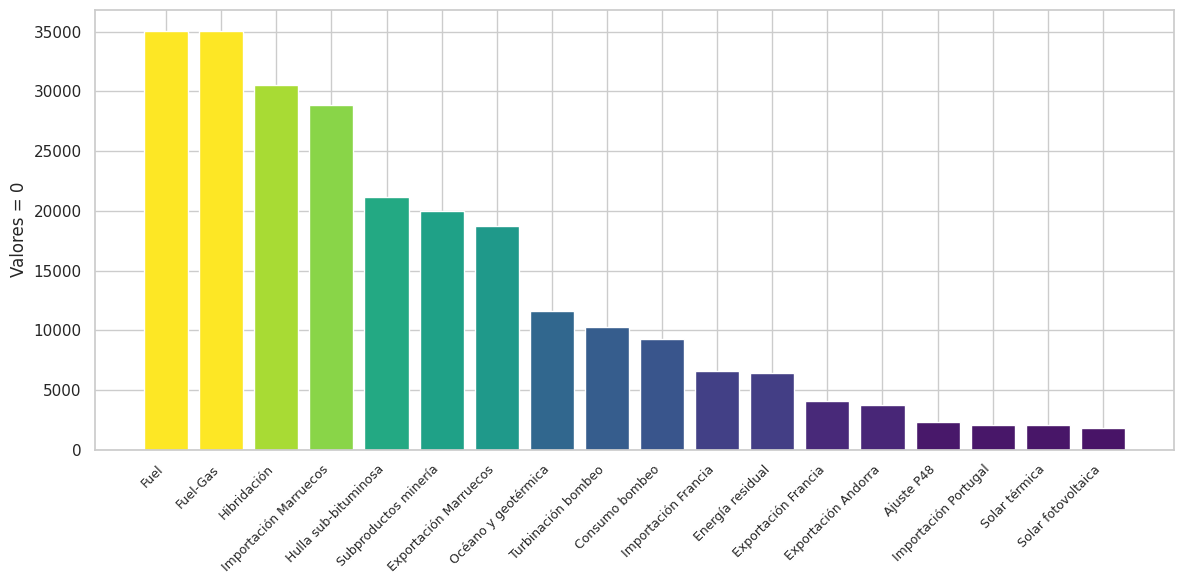

In [26]:
# 1. Calcular número de ceros por columna (numéricas)
ceros = (df == 0).sum(numeric_only=True)

# 2. Eliminar columnas categóricas con ceros válidos por diseño
excluir = ['DiaSemana', 'TipoDia', 'Estacion', 'HoraTrabajo', 'hour', 'HoraDia']
ceros = ceros.drop(labels=[col for col in excluir if col in ceros.index], errors='ignore')

# 3. Filtrar columnas con al menos un cero
ceros = ceros[ceros > 0]

# 4. Ordenar de mayor a menor y seleccionar los 18 primeros
ceros = ceros.sort_values(ascending=False).head(18)

# 5. Graficar en vertical
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(ceros.values / ceros.values.max())
plt.bar(ceros.index, ceros.values, color=colors)
plt.ylabel("Valores = 0")
plt.title("")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

Observamos el % de ceros de las columnas

In [27]:
porcentaje_ceros = (df == 0).sum(numeric_only=True) / len(df) * 100
porcentaje_ceros.sort_values(ascending=False).head(20)

Fuel                     99.974341
Fuel-Gas                 99.974341
Hibridación              87.059159
Importación Marruecos    82.275125
TipoDia                  69.585175
Hulla sub-bituminosa     60.427655
Subproductos minería     57.091946
HoraTrabajo              54.181041
Exportación Marruecos    53.502495
Océano y geotérmica      33.191732
Turbinación bombeo       29.208838
Consumo bombeo           26.506058
Estacion                 24.698503
Importación Francia      18.751247
Energía residual         18.295082
DiaSemana                14.300784
Exportación Francia      11.489665
Exportación Andorra      10.605845
Ajuste P48                6.486101
Importación Portugal      5.864576
dtype: float64

In [28]:
# 1. Agrupar renovables complementarias en 'Otras renovables'
df['Otras renovables'] = (
    df['Otras renovables']
    + df.get('Residuos domésticos', 0)
    + df.get('Hibridación', 0)
    + df.get('Océano y geotérmica', 0)
)

# 2. Crear nueva columna: 'Otras no renovables' con las no renovables agrupadas
df['Otras no renovables'] = (
    df.get('Subproductos minería', 0)
    + df.get('Fuel', 0)
    + df.get('Derivados petróleo o carbón', 0)
    + df.get('Fuel-Gas', 0)
    + df.get('Hulla sub-bituminosa', 0)
    + df.get('Hulla antracita', 0)
    + df.get('Residuos varios', 0)
    + df.get('Residuos no renovables', 0)
)

# 3. Eliminar las columnas originales
columnas_a_eliminar = [
    'Residuos domésticos', 'Hibridación', 'Océano y geotérmica',
    'Subproductos minería', 'Fuel', 'Derivados petróleo o carbón',
    'Fuel-Gas', 'Hulla sub-bituminosa', 'Hulla antracita', 'Residuos varios', 'Residuos no renovables'
]

df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

In [29]:
df = df.drop('Eólica terrestre', axis=1)

In [30]:
df

date  hour  Turbinación bombeo  Exportación Andorra  Nuclear  \
1      2021-01-01     0               86.80                -40.0  7106.10   
2      2021-01-01     1                0.00                -37.0  7106.10   
3      2021-01-01     2                0.00                -35.0  7106.10   
4      2021-01-01     3                0.00                -34.0  7106.10   
5      2021-01-01     4                0.00                -34.0  7105.10   
...           ...   ...                 ...                  ...      ...   
35071  2024-12-31    18             1158.40                -49.0  7089.00   
35072  2024-12-31    19              705.05                -49.0  7089.00   
35073  2024-12-31    20              192.05                -43.0  7089.00   
35074  2024-12-31    21               17.50                -63.0  7089.00   
35075  2024-12-31    22               17.50                -14.0  1772.25   

       Solar fotovoltaica  Hidráulica  Generación + Bombeo + Cable  \
1                   1.100     5092.90                    25218.400   
2                  10.700     4075.00                    24264.800   
3                   0.000     3468.00                    22848.700   
4                   0.000     3306.40                    22629.100   
5                   0.000     2988.60                    22540.800   
...                   ...         ...                          ...   
35071              12.300     7021.35                    29588.800   
35072               1.300     5843.45                    28984.700   
35073               1.400     4714.45                    26906.000   
35074               0.800     3192.60                    24733.225   
35075               0.175      657.05                     5875.825   

       Exportación Marruecos  Exportación Francia  Gas Natural Cogeneración  \
1                        0.0             -2463.40                  2091.300   
2                        0.0             -3561.00                  2080.400   
3                        0.0             -3561.00                  2074.200   
4                        0.0             -3746.00                  2071.900   
5                        0.0             -3746.00                  2073.400   
...                      ...                  ...                       ...   
35071                 -220.0              -185.00                  1718.000   
35072                 -190.0              -185.00                  1701.800   
35073                    0.0              -185.00                  1695.700   
35074                    0.0               -46.25                  1678.200   
35075                    0.0              -130.50                   412.575   

       Importación Portugal  Cogeneración  Hidráulica no UGH  \
1                   615.100        2175.2             964.30   
2                   482.300        2164.3             938.70   
3                   600.000        2158.1             930.80   
4                   193.600        2155.8             857.40   
5                   155.200        2157.3             854.30   
...                     ...           ...                ...   
35071               326.525        1762.1             641.30   
35072               252.875        1742.7             637.40   
35073               262.400        1736.6             629.70   
35074                69.950        1719.1             608.20   
35075               100.250         422.8             150.85   

       Generación P48 total  Ciclo combinado  Biomasa  Exportación Portugal  \
1                 26920.700         2815.700   454.90               -333.20   
2                 25866.900         2555.200   456.70               -374.00   
3                 25203.900         2289.300   464.60               -902.20   
4                 24899.200         1989.600   468.60              -1216.70   
5                 24735.800         1826.000   469.00              -1274.40   
...                     ...              ...      ...  

## Valores atípicos

En este caso, no vamos a contemplar la existencia de valores atípicos, pues en el mercado eléctrico, estos valores suenel deberse a circunstancias concretas del distema, como por ejemplo, la escase de producción renovable. Por lo que estos datos resultan relevntes para comprender el mercado.




In [31]:
df.columns

Index(['date', 'hour', 'Turbinación bombeo', 'Exportación Andorra', 'Nuclear',
       'Solar fotovoltaica', 'Hidráulica', 'Generación + Bombeo + Cable',
       'Exportación Marruecos', 'Exportación Francia',
       'Gas Natural Cogeneración', 'Importación Portugal', 'Cogeneración',
       'Hidráulica no UGH', 'Generación P48 total', 'Ciclo combinado',
       'Biomasa', 'Exportación Portugal', 'Exportación Total',
       'Generación + Interconexiones', 'Importación Francia', 'Biogás',
       'Solar térmica', 'Importación Total', 'Enlace Baleares', 'Carbón',
       'Hidráulica UGH', 'Importación Marruecos', 'Consumo bombeo',
       'Demanda Peninsular', 'Total Almacenamiento', 'Energía residual',
       'Ajuste P48', 'Otras renovables', 'Eólica', 'SPOT_ESP', 'SPOT_FR',
       'SPOT_POR', 'GenCO2', 'PrecioGas', 'PVPC', 'DiaSemana', 'TipoDia',
       'HoraDia', 'HoraTrabajo', 'Año', 'Mes', 'Estacion', 'tmed_hourly',
       'pmed_hourly', 'Otras no renovables'],
      dtype='object')

<ipython-input-32-371676976109>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-32-371676976109>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-32-371676976109>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-32-371676976109>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


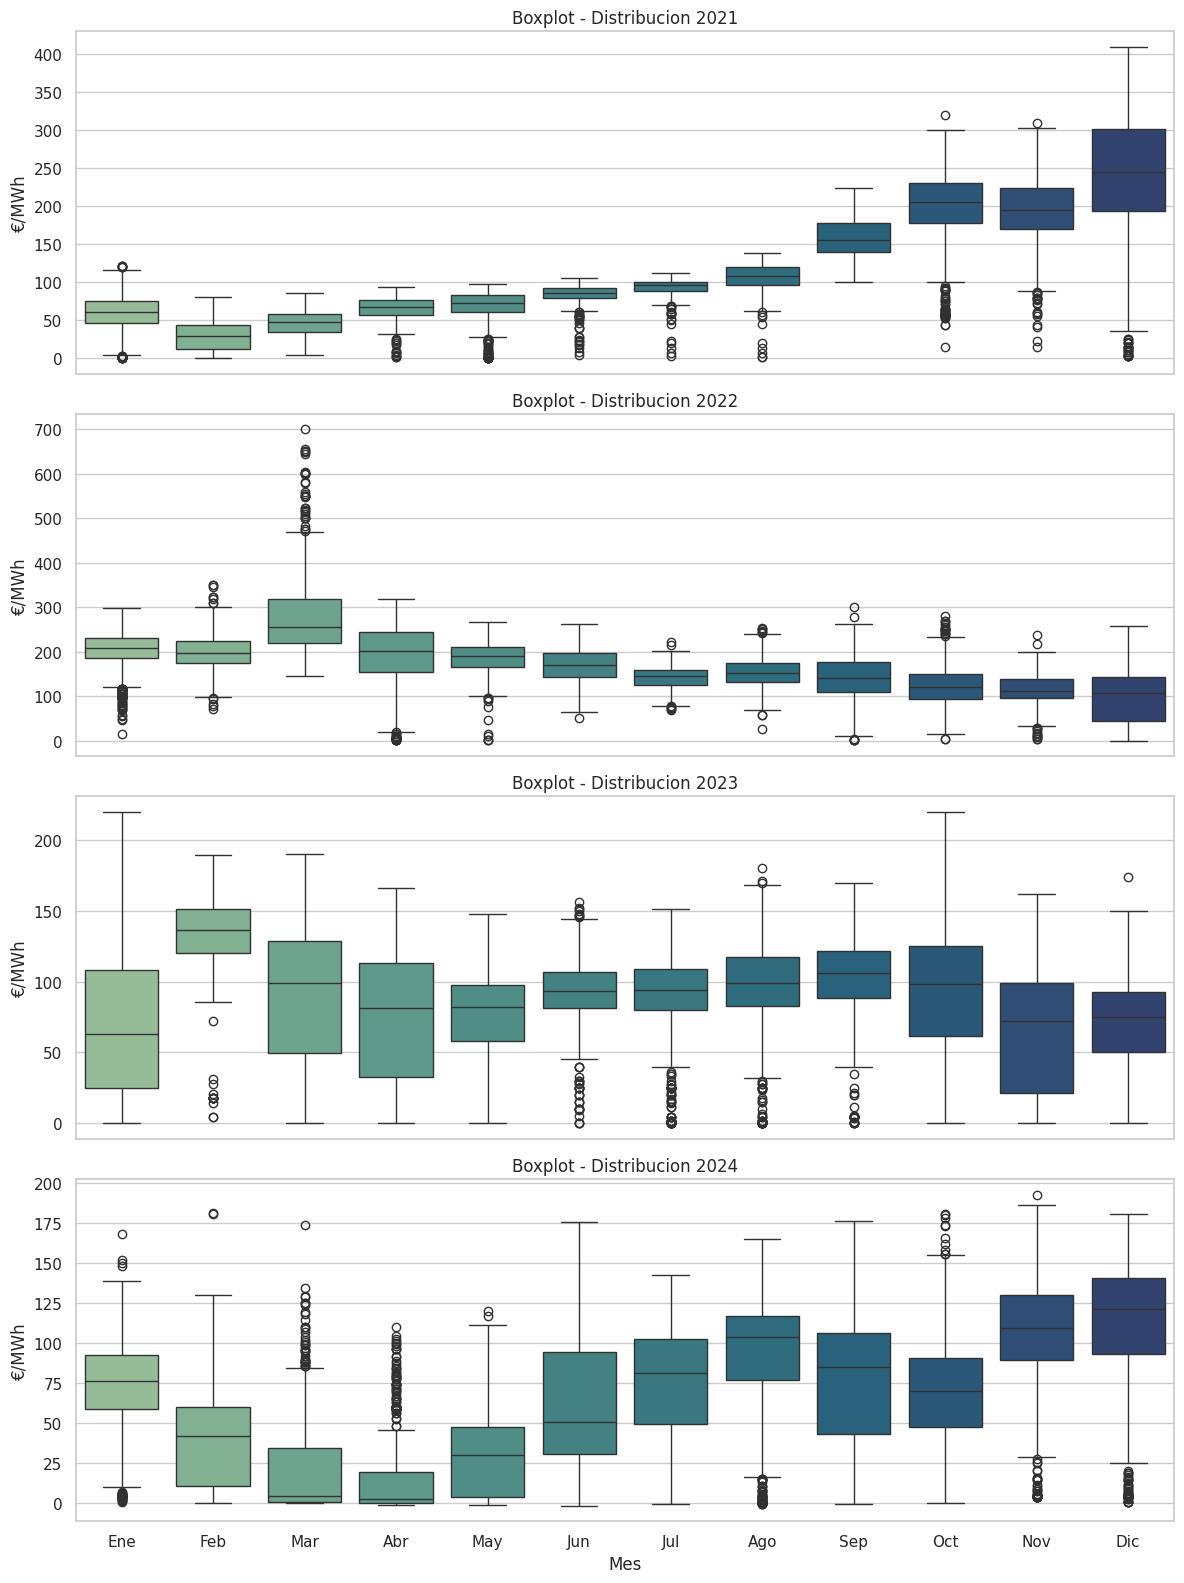

In [32]:
df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')
df['Año'] = df['datetime'].dt.year
df['Mes'] = df['datetime'].dt.month

# Ordenar meses por nombre
meses_nombre = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
df['Mes_nombre'] = df['Mes'].apply(lambda x: meses_nombre[x-1])

# Años únicos
años = sorted(df['Año'].unique())

# Crear subplots
fig, axes = plt.subplots(nrows=len(años), ncols=1, figsize=(12, 4 * len(años)), sharex=True)

for i, año in enumerate(años):
    ax = axes[i]
    data = df[df['Año'] == año]
    sns.boxplot(
        data=data,
        x='Mes_nombre',
        y='SPOT_ESP',
        ax=ax,
        palette='crest',
        showfliers=True
    )
    ax.set_title(f"Boxplot - Distribucion {año}")
    ax.set_ylabel("€/MWh")
    ax.set_xlabel("Mes")

axes[-1].set_xlabel("Mes")
plt.tight_layout()
plt.savefig("temperatura.png", dpi=300)
plt.show()

## Disitribuciones - Análisis general de los datos



###¿Cómo influye el calendario al precio SPOT?

In [33]:
import pandas as pd

# Asegúrate de que SPOT_ESP es numérico y no tiene NaN
df['SPOT_ESP'] = pd.to_numeric(df['SPOT_ESP'], errors='coerce')
spot = df['SPOT_ESP'].dropna()

# Calcula los cuartiles
cuartiles = spot.quantile([0.25, 0.50, 0.75]).rename({
    0.25: '1er cuartil (Q1)',
    0.50: 'Mediana (Q2)',
    0.75: '3er cuartil (Q3)'
})

print("Cuartiles de SPOT_ESP:")
print(cuartiles)

Cuartiles de SPOT_ESP:
1er cuartil (Q1)     60.05
Mediana (Q2)         98.59
3er cuartil (Q3)    144.66
Name: SPOT_ESP, dtype: float64


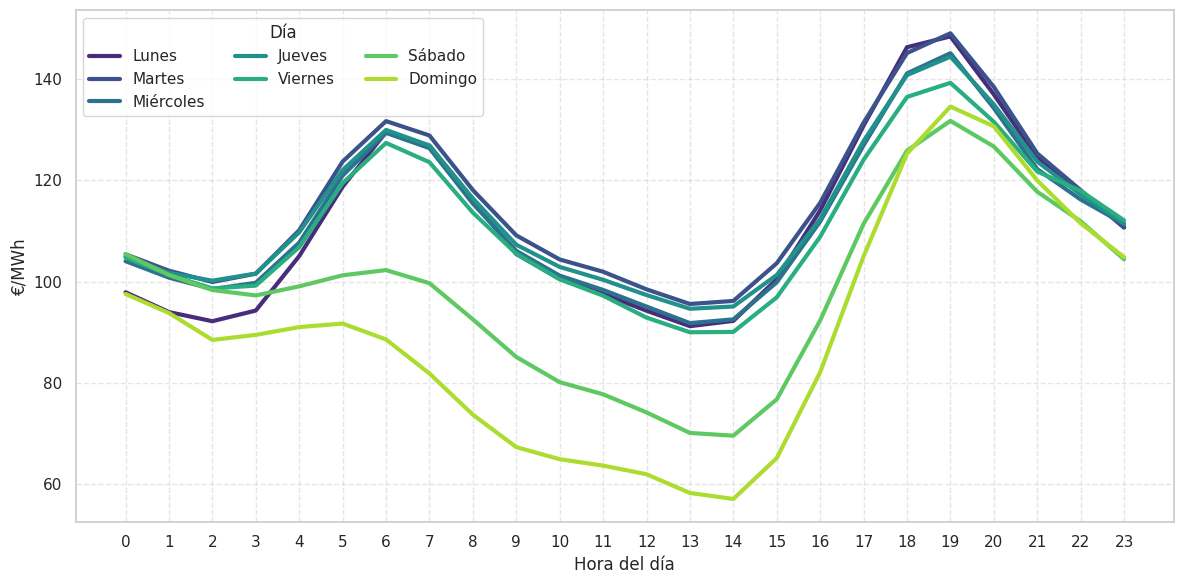

In [34]:
colores = sns.color_palette("viridis", 7)
plt.figure(figsize=(12, 6))
for i in range(7):
    media = df[df['DiaSemana'] == i].groupby('hour')['SPOT_ESP'].mean()
    plt.plot(
        media.index,
        media.values,
        label=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'][i],
        linewidth=3,
        color=colores[i]
    )
plt.title("", fontsize=14, weight='bold')
plt.xlabel("Hora del día")
plt.ylabel("€/MWh")
plt.xticks(range(24))  # Mostrar todas las horas
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Día", ncol=3)
plt.tight_layout()
plt.show()

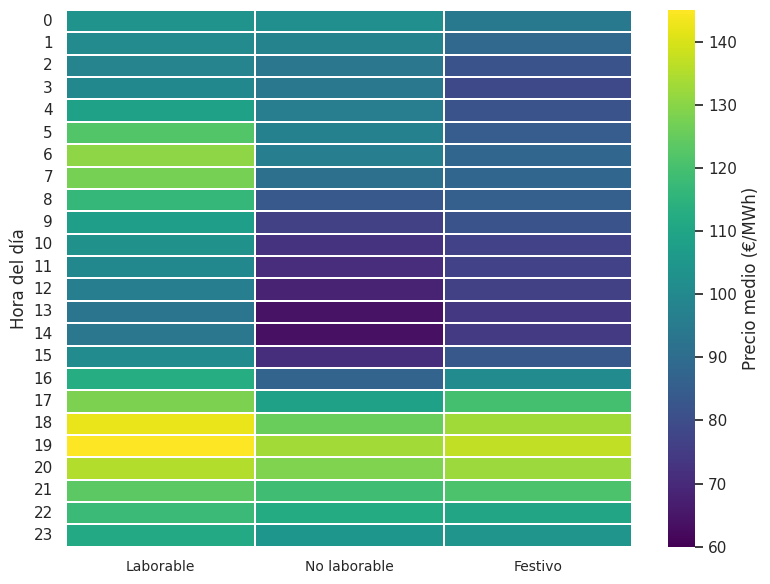

In [35]:
df['LaTipoDiaboral'] = df['TipoDia'].astype(int).astype('category')

# 2. Crear tabla pivote
df_plot = df[['TipoDia', 'hour', 'SPOT_ESP']].dropna()
pivot_lab = df_plot.pivot_table(
    index='hour',
    columns='TipoDia',
    values='SPOT_ESP',
    aggfunc='mean',
    observed=False
)

# 3. Definir límites de color
precio_min = 60
precio_max = 145

# 4. Dibujar heatmap con viridis
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("viridis", as_cmap=True)

ax = sns.heatmap(
    pivot_lab,
    cmap=cmap,
    vmin=precio_min,
    vmax=precio_max,
    cbar_kws={'label': 'Precio medio (€/MWh)'},
    linewidths=0.3,
    linecolor='white'
)

# 5. Etiquetas personalizadas
ax.set_xticklabels(['Laborable', 'No laborable', 'Festivo'], rotation=0, ha='center', fontsize=10)

# 6. Título y ejes
plt.title("", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("Hora del día")
plt.tight_layout()
plt.show()

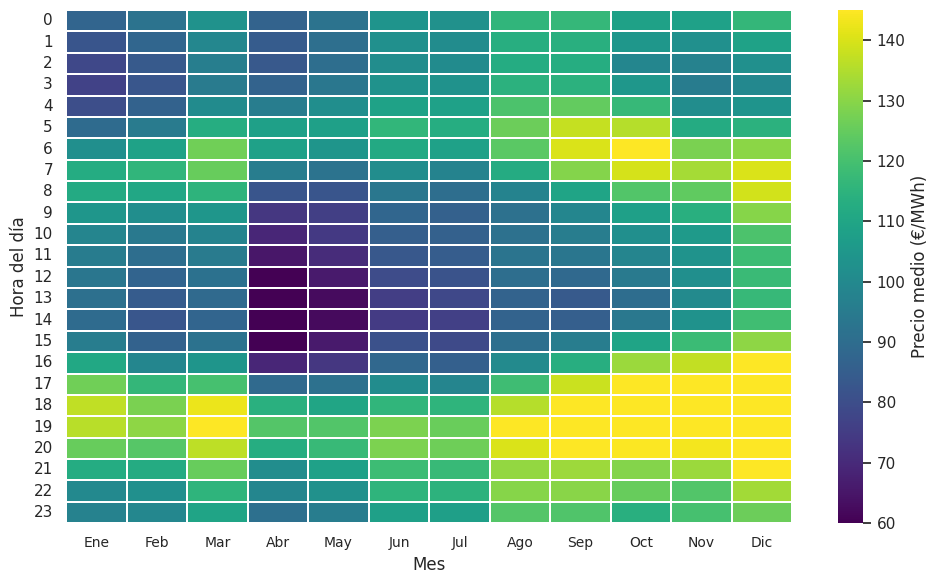

In [36]:
df['Mes'] = pd.to_datetime(df['date']).dt.month
df['Mes'] = df['Mes'].astype(int).astype('category')

# 2. Crear tabla pivote
df_plot = df[['Mes', 'hour', 'SPOT_ESP']].dropna()
pivot_mes = df_plot.pivot_table(
    index='hour',
    columns='Mes',
    values='SPOT_ESP',
    aggfunc='mean',
    observed=False
)

# 3. Rangos de color
precio_min = 60
precio_max = 145
# 4. Dibujar heatmap
plt.figure(figsize=(10, 6))
cmap = sns.color_palette("viridis", as_cmap=True)

ax = sns.heatmap(
    pivot_mes,
    cmap=cmap,
    vmin=precio_min,
    vmax=precio_max,
    cbar_kws={'label': 'Precio medio (€/MWh)'},
    linewidths=0.3,
    linecolor='white'
)

# 5. Etiquetas personalizadas
meses_str = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
ax.set_xticklabels(meses_str, rotation=0, ha='center', fontsize=10)

# 6. Título y ejes
plt.title("", fontsize=14, weight='bold')
plt.xlabel("Mes")
plt.ylabel("Hora del día")
plt.tight_layout()
plt.show()

In [37]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 1) Día objetivo
fecha_objetivo = df['date'].iloc[17447]
df_dia = df[df['date'] == fecha_objetivo].copy()

# 2) Columnas de tecnologías
renovables = [
    'Solar fotovoltaica',
    'Solar térmica',
    'Eólica',
    'Hidráulica',
    'Hidráulica no UGH',
    'Biomasa',
    'Turbinación bombeo',
    'Otras renovables', 'Biogás',
]

no_renovables = [
    'Nuclear',
    'Ciclo combinado',
    'Carbón',
    'Cogeneración',
    'Gas Natural Cogeneración',
    'Otras no renovables', 'Energía residual',
]

# 3) Agrupar generación por hora
df_dia['renovable'] = df_dia[renovables].sum(axis=1)
df_dia['no_renovable'] = df_dia[no_renovables].sum(axis=1)

# Agrupamos por hora para la gráfica
grouped = df_dia.groupby('hour')[['renovable', 'no_renovable', 'SPOT_ESP']].sum().reset_index()

# 4) Crear la figura
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 5a) Barras apiladas
fig.add_trace(go.Bar(
    x=grouped['hour'],
    y=grouped['renovable'],
    name='Renovables',
    marker=dict(color='#8FBC8F'),
    offsetgroup='gen'
), secondary_y=False)

fig.add_trace(go.Bar(
    x=grouped['hour'],
    y=grouped['no_renovable'],
    name='No Renovables',
    marker=dict(color='#2F4F4F'),
    offsetgroup='gen',
    base=grouped['renovable']
), secondary_y=False)

# 5b) Línea de precio SPOT
fig.add_trace(go.Scatter(
    x=grouped['hour'],
    y=grouped['SPOT_ESP'],
    name='Precio SPOT',
    mode='lines+markers',
    line=dict(color='#FFA500', width=3)
), secondary_y=True)

# 6) Layout
fig.update_layout(
    title=f'Generación Renovable vs No Renovable y Precio SPOT — {fecha_objetivo}',
    barmode='stack',
    xaxis=dict(title='Hora'),
    yaxis=dict(title='MWh'),
    yaxis2=dict(title='Precio SPOT (€/MWh)', overlaying='y', side='right'),
    legend=dict(x=1.02, y=1),
    width=1000,
    height=500
)

fig.show()

In [38]:
df.columns

Index(['date', 'hour', 'Turbinación bombeo', 'Exportación Andorra', 'Nuclear',
       'Solar fotovoltaica', 'Hidráulica', 'Generación + Bombeo + Cable',
       'Exportación Marruecos', 'Exportación Francia',
       'Gas Natural Cogeneración', 'Importación Portugal', 'Cogeneración',
       'Hidráulica no UGH', 'Generación P48 total', 'Ciclo combinado',
       'Biomasa', 'Exportación Portugal', 'Exportación Total',
       'Generación + Interconexiones', 'Importación Francia', 'Biogás',
       'Solar térmica', 'Importación Total', 'Enlace Baleares', 'Carbón',
       'Hidráulica UGH', 'Importación Marruecos', 'Consumo bombeo',
       'Demanda Peninsular', 'Total Almacenamiento', 'Energía residual',
       'Ajuste P48', 'Otras renovables', 'Eólica', 'SPOT_ESP', 'SPOT_FR',
       'SPOT_POR', 'GenCO2', 'PrecioGas', 'PVPC', 'DiaSemana', 'TipoDia',
       'HoraDia', 'HoraTrabajo', 'Año', 'Mes', 'Estacion', 'tmed_hourly',
       'pmed_hourly', 'Otras no renovables', 'datetime', 'Mes_nombre',
   

In [39]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

colores_custom = {
    'Hidráulica':               '#4fc3f7',
    'Hidráulica no UGH':        '#AFEEEE',
    'Turbinación bombeo':       '#0288d1',
    'Nuclear':                  '#ce93d8',
    'Ciclo combinado':          '#607d8b', # Ya fue eliminada, pero por si se usa aparte
    'Gas Natural Cogeneración': '#bcaaa4',
    'Solar fotovoltaica':       '#fff176',
    'Solar térmica':            '#fff176',
    'Eólica':                   '#a5d6a7',
    'Biomasa':                  '#8bc34a',
    'Carbón':                   '#8d6e63',
    'Cogeneración':             '#ffb74d',
    'Residuos no renovables':   '#191970',
    'Otras renovables':         '#6B8E23',
    'Consumo bombeo':           '#d84315',
    'Exportación Total':        '#FDF5E6',
    'Importación Total':        '#F5FFFA',

}

# 1) Día objetivo
fecha_objetivo = df['date'].iloc[22237]
df_dia = df[df['date'] == fecha_objetivo].copy()

# 2) Definir tecnologías
pos_techs = [c for c in [
    'Hidráulica', 'Hidráulica no UGH', 'Turbinación bombeo', 'Nuclear',
    'Ciclo combinado', 'Gas Natural Cogeneración', 'Solar fotovoltaica',
    'Solar térmica', 'Biomasa', 'Carbón', 'Eólica', 'Cogeneración',
    'Residuos no renovables', 'Otras renovables',
    'Importación Total',  'Otras no renovables',
] if c in df.columns]

neg_techs = [c for c in [
    'Consumo bombeo', 'Exportación Total'
] if c in df.columns]
# 3) Agrupar por hora
columnas_extra = ['SPOT_ESP', 'PVPC', 'Demanda Peninsular', 'Generación P48 total']
grouped = (
    df_dia
    .groupby('hour')[pos_techs + neg_techs + columnas_extra]
    .sum()
    .reset_index()
)

# 4) Crear figura
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 5) Barras positivas
for tech in pos_techs:
    fig.add_trace(
        go.Bar(
            x=grouped['hour'],
            y=grouped[tech],
            name=tech,
            marker=dict(color=colores_custom.get(tech, '#888888')),
            offsetgroup='pos'
        ),
        secondary_y=False
    )

# 6) Barras negativas (ya con signo negativo en df → no usar base=0)
for tech in neg_techs:
    fig.add_trace(
        go.Bar(
            x=grouped['hour'],
            y=grouped[tech],
            name=tech,
            marker=dict(color=colores_custom.get(tech, '#888888'))
        ),
        secondary_y=False
    )

# 7) Demanda (línea negra punteada)
fig.add_trace(
    go.Scatter(
        x=grouped['hour'],
        y=grouped['Demanda Peninsular'],
        name='Demanda',
        mode='lines+markers',
        line=dict(color='black', width=2, dash='dot')
    ),
    secondary_y=False
)

# 8) Precio SPOT (línea roja continua)
fig.add_trace(
    go.Scatter(
        x=grouped['hour'],
        y=grouped['SPOT_ESP'],
        name='Precio SPOT',
        mode='lines',
        line=dict(color='red', width=2)
    ),
    secondary_y=True
)
fig.add_trace(
    go.Scatter(
        x=grouped['hour'],
        y=grouped['Generación P48 total'],
        name='Generación total',
        mode='lines',
        line=dict(color='blue', width=2, dash='solid')
    ),
    secondary_y=False
)

fig.update_layout(
    title=f'Generación, Demanda y Precio spot — {fecha_objetivo}',
    barmode='relative',
    xaxis=dict(title='Hora del día'),
    yaxis=dict(title='Generación / Demanda (MWh)'),
    yaxis2=dict(
        title='Precio (€/MWh)',
        overlaying='y',
        side='right',
        dtick=20
    ),
    legend=dict(
        orientation="h",  # horizontal
        yanchor="top",
        y=-0.25,
        xanchor="left",
        x=0,
        traceorder='normal',
        font=dict(size=10),
        title=None
    ),
    margin=dict(b=200),  # margen inferior para la leyenda
    height=700,
    width=1100
)

fig.show()

### ¿Qué tecnologías generan más a lo largo del año?

In [40]:
tecnologias_generacion = [
    'Hidráulica', 'Hidráulica no UGH', 'Turbinación bombeo',
    'Nuclear', 'Ciclo combinado', 'Gas Natural Cogeneración',
    'Solar fotovoltaica', 'Solar térmica', 'Biomasa',
    'Carbón', 'Eólica', 'Cogeneración','Otras renovables',
    'Otras no renovables',
]

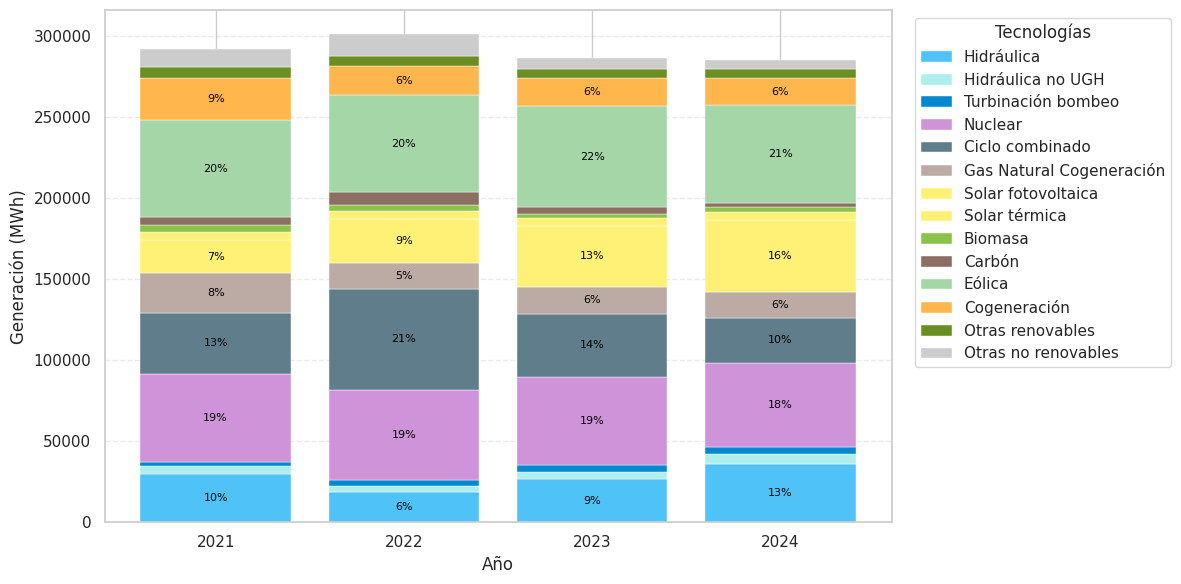

In [41]:
generacion_anual = df.groupby('Año')[tecnologias_generacion].sum() / 1_000  # en kMWh

# 2. Colores personalizados
colores = [colores_custom.get(col, '#cccccc') for col in generacion_anual.columns]

# 3. Crear figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# 4. Dibujar barras apiladas
bottoms = [0] * len(generacion_anual)
years = generacion_anual.index.tolist()

for i, tech in enumerate(generacion_anual.columns):
    valores = generacion_anual[tech].values
    ax.bar(
        years,
        valores,
        bottom=bottoms,
        label=tech,
        color=colores[i],
        edgecolor='white',
        linewidth=0.3
    )
    for j, v in enumerate(valores):
        total = generacion_anual.iloc[j].sum()
        pct = v / total * 100
        if pct > 5:
            ax.text(
                years[j],
                bottoms[j] + v / 2,
                f'{pct:.0f}%',
                ha='center',
                va='center',
                fontsize=8,
                color='black'
            )
    bottoms = [sum(x) for x in zip(bottoms, valores)]

# 5. Estética
ax.set_ylabel('Generación (MWh)')
ax.set_xlabel('Año')
ax.set_title((''), fontsize=14, weight='bold')
ax.set_xticks(years)
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.legend(title='Tecnologías', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
variables_analisis = [
    'Solar fotovoltaica', 'Eólica', 'Hidráulica', 'Nuclear',
    'Ciclo combinado', 'Biomasa', 'Carbón',
    'Cogeneración', 'Gas Natural Cogeneración',
    'Otras renovables', 'Otras no renovables',
    'Demanda Peninsular', 'PVPC', 'SPOT_ESP', 'PrecioGas'
]

In [43]:
# Asegurarse de que solo hay datos numéricos
df_corr = df[variables_analisis].copy()

# Correlación de Pearson
correlaciones = df_corr.corr()

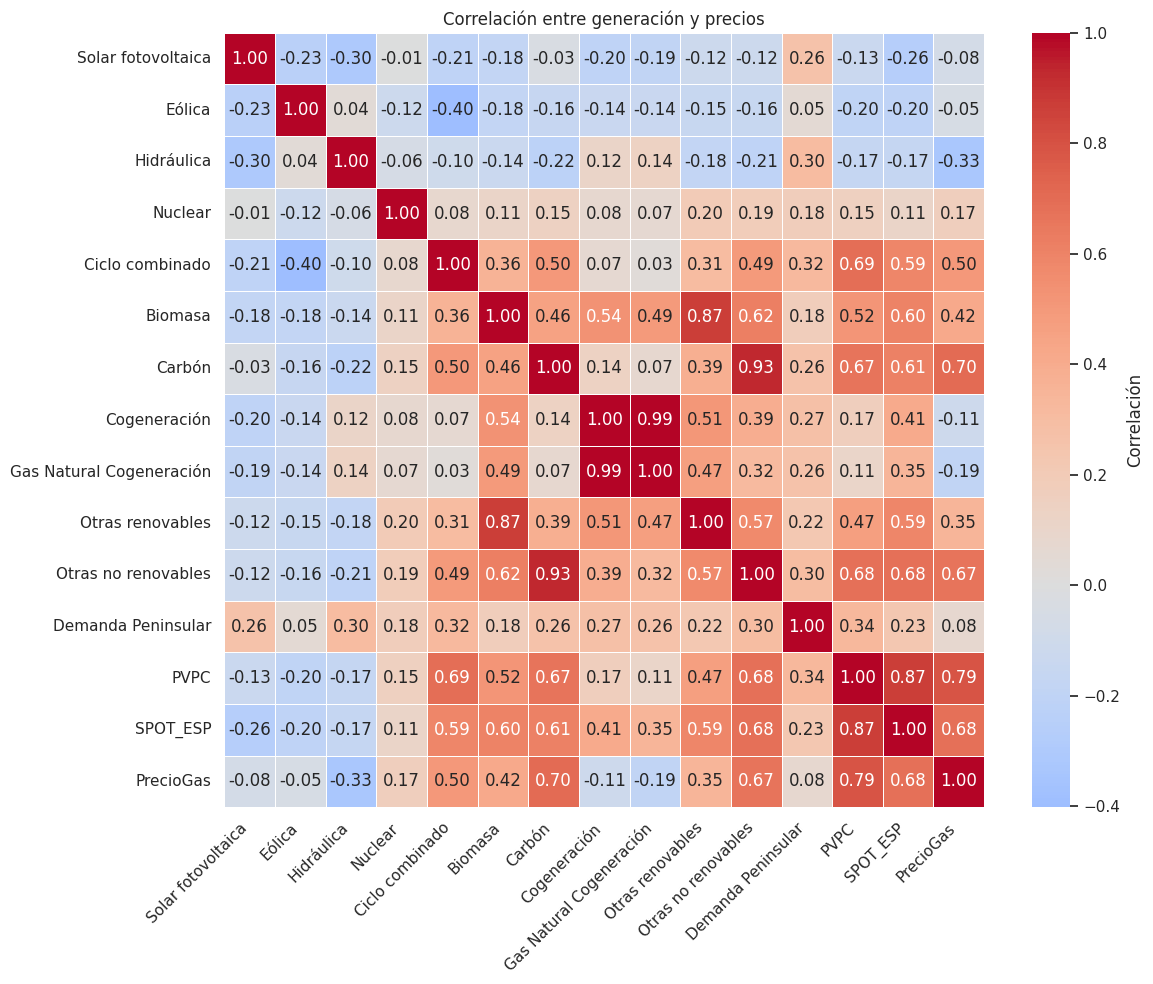

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={'label': 'Correlación'})
plt.title("Correlación entre generación y precios")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

📌 1. Las tecnologías renovables tienen correlación negativa con los precios
	•	Solar fotovoltaica, eólica e hidráulica presentan correlaciones negativas con el PVPC, SPOT_ESP y Precio del gas.
	•	Esto indica que cuando hay mayor generación renovable, los precios tienden a ser más bajos.
	•	Especialmente:
	•	Solar fotovoltaica → -0.26 con SPOT_ESP
	•	Eólica → -0.20 con SPOT_ESP
	•	Hidráulica → -0.17 con PVPC

📉 Conclusión: Las renovables ayudan a abaratar el precio de la electricidad.

⸻

📌 2. Las fuentes fósiles y no renovables están asociadas a precios altos
	•	Ciclo combinado, Carbón, Cogeneración y Otras no renovables muestran una fuerte correlación positiva con el PVPC, SPOT_ESP y PrecioGas:
	•	Ciclo combinado → 0.69 con PVPC y 0.87 con SPOT_ESP.
	•	Otras no renovables → 0.67 con PVPC.
	•	Carbón → 0.60 con SPOT_ESP.

🔥 Conclusión: La dependencia de fuentes no renovables eleva los precios de mercado.

⸻

📌 3. La demanda también influye, pero no de forma dominante
	•	Demanda Peninsular tiene correlación positiva moderada con los precios:
	•	0.34 con PVPC
	•	0.28 con SPOT_ESP
	•	Esto refleja que la demanda influye, pero no explica sola la variación del precio.

⸻


<Figure size 1400x800 with 0 Axes>

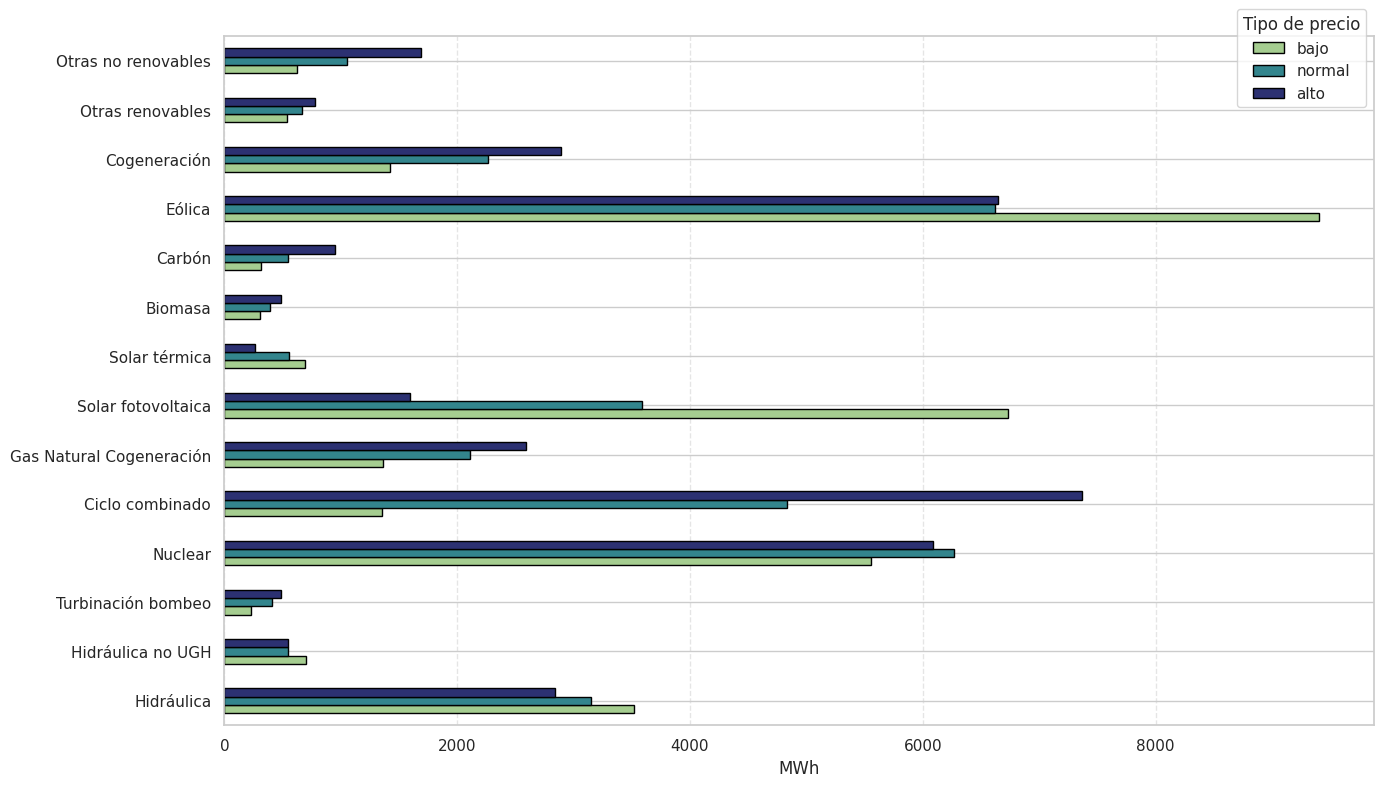

In [45]:
# 1. Definir umbrales percentiles 10 y 90
q10 = df['SPOT_ESP'].quantile(0.10)
q90 = df['SPOT_ESP'].quantile(0.90)

# 2. Clasificación de precios
df['tipo_precio'] = 'normal'
df.loc[df['SPOT_ESP'] > q90, 'tipo_precio'] = 'alto'
df.loc[df['SPOT_ESP'] < q10, 'tipo_precio'] = 'bajo'

# 3. Tecnologías de generación
tecnologias = [
    'Hidráulica', 'Hidráulica no UGH', 'Turbinación bombeo',
    'Nuclear', 'Ciclo combinado', 'Gas Natural Cogeneración',
    'Solar fotovoltaica', 'Solar térmica', 'Biomasa',
    'Carbón', 'Eólica', 'Cogeneración','Otras renovables',
    'Otras no renovables',
]

# 4. Agrupar y ordenar
comparacion = df.groupby('tipo_precio')[tecnologias].mean().T
comparacion = comparacion.reindex(columns=['bajo', 'normal', 'alto'])

# 5. Gráfico sin etiquetas
plt.figure(figsize=(14, 8))
ax = comparacion.plot(
    kind='barh',
    colormap='crest',
    edgecolor='black',
    figsize=(14, 8)
)

# 6. Estética
plt.title("", fontsize=15, weight='bold')
plt.xlabel("MWh", fontsize=12)
plt.ylabel("", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Leyenda en la esquina superior derecha
plt.legend(
    title="Tipo de precio",
    loc='upper right',
    bbox_to_anchor=(1, 1.05)
)

plt.tight_layout()
plt.show()

## Estudiar la variable objetivo

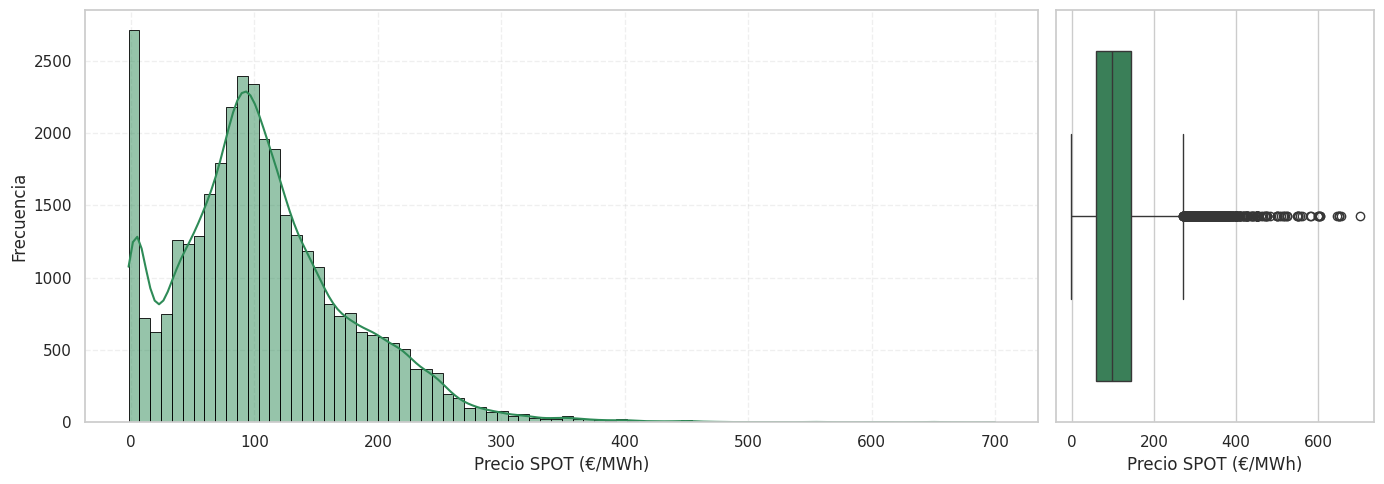

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [3, 1]})

# Histograma con KDE
sns.histplot(df['SPOT_ESP'], bins=80, kde=True, color='seagreen', edgecolor='black', ax=axes[0])
axes[0].set_title("", fontsize=14, weight='bold')
axes[0].set_xlabel("Precio SPOT (€/MWh)")
axes[0].set_ylabel("Frecuencia")
axes[0].grid(True, linestyle='--', alpha=0.3)

# Boxplot
sns.boxplot(x=df['SPOT_ESP'], color='seagreen', ax=axes[1], orient='h')
axes[1].set_title("", fontsize=14, weight='bold')
axes[1].set_xlabel("Precio SPOT (€/MWh)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

Coeficiente de Pearson

In [47]:
x = df['SPOT_ESP'].dropna()
media = x.mean()
moda = x.mode().iloc[0]
std = x.std()

ap1 = (media - moda) / std
ap1

np.float64(1.5094316887273793)

📌 1. ¿Qué es la estacionalidad?

Es un patrón que se repite periódicamente a lo largo del tiempo. Puede deberse a factores como estaciones del año, días de la semana, horarios, etc.

🔁 Ejemplos de estacionalidad:
	•	El precio de la electricidad baja por la noche y sube por la tarde.
	•	Las ventas de helado suben en verano.
	•	La generación solar es mayor durante el día y nula por la noche.

➡️ Se repite a intervalos regulares.

⸻

📌 2. ¿Qué es la estacionariedad?

Una serie es estacionaria si sus propiedades estadísticas (media, varianza, autocorrelación) se mantienen constantes en el tiempo.

✅ Si la serie:
	•	No tiene tendencia,
	•	No tiene cambio en la varianza,
	•	No depende del tiempo directamente…

Entonces es estacionaria.


Primero vamos a ver si la serie es estacionaria:

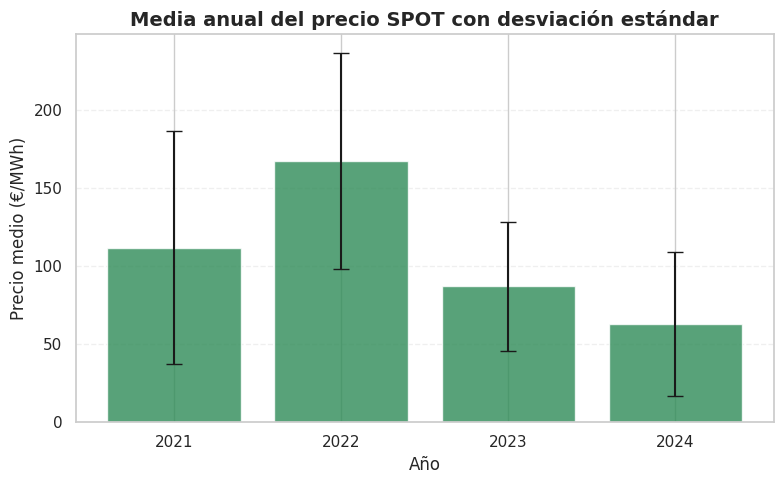

In [48]:
import matplotlib.pyplot as plt

# Si ya tienes el resumen en un DataFrame llamado resumen:
resumen = df.groupby('Año')['SPOT_ESP'].agg(['mean', 'std'])

# Crear gráfico
plt.figure(figsize=(8, 5))
plt.bar(
    resumen.index.astype(str),
    resumen['mean'],
    yerr=resumen['std'],
    capsize=6,
    color='seagreen',
    alpha=0.8
)

plt.title("Media anual del precio SPOT con desviación estándar", fontsize=14, weight='bold')
plt.xlabel("Año")
plt.ylabel("Precio medio (€/MWh)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [49]:
# Ensure the 'date' column is a pandas datetime object
df['date'] = pd.to_datetime(df['date'])

df['Año'] = df['date'].dt.year
resumen = df.groupby('Año')['SPOT_ESP'].agg(['mean', 'std'])

In [50]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(df['SPOT_ESP'].dropna())
estadistico_adf = resultado_adf[0]
p_valor = resultado_adf[1]

In [51]:
p_valor

np.float64(6.4642518602819775e-09)

In [52]:
estadistico_adf

np.float64(-6.608533299257498)

In [53]:
df_sin_duplicados = df.drop_duplicates(subset='datetime')

serie = df_sin_duplicados.set_index('datetime')['SPOT_ESP'].asfreq('h')

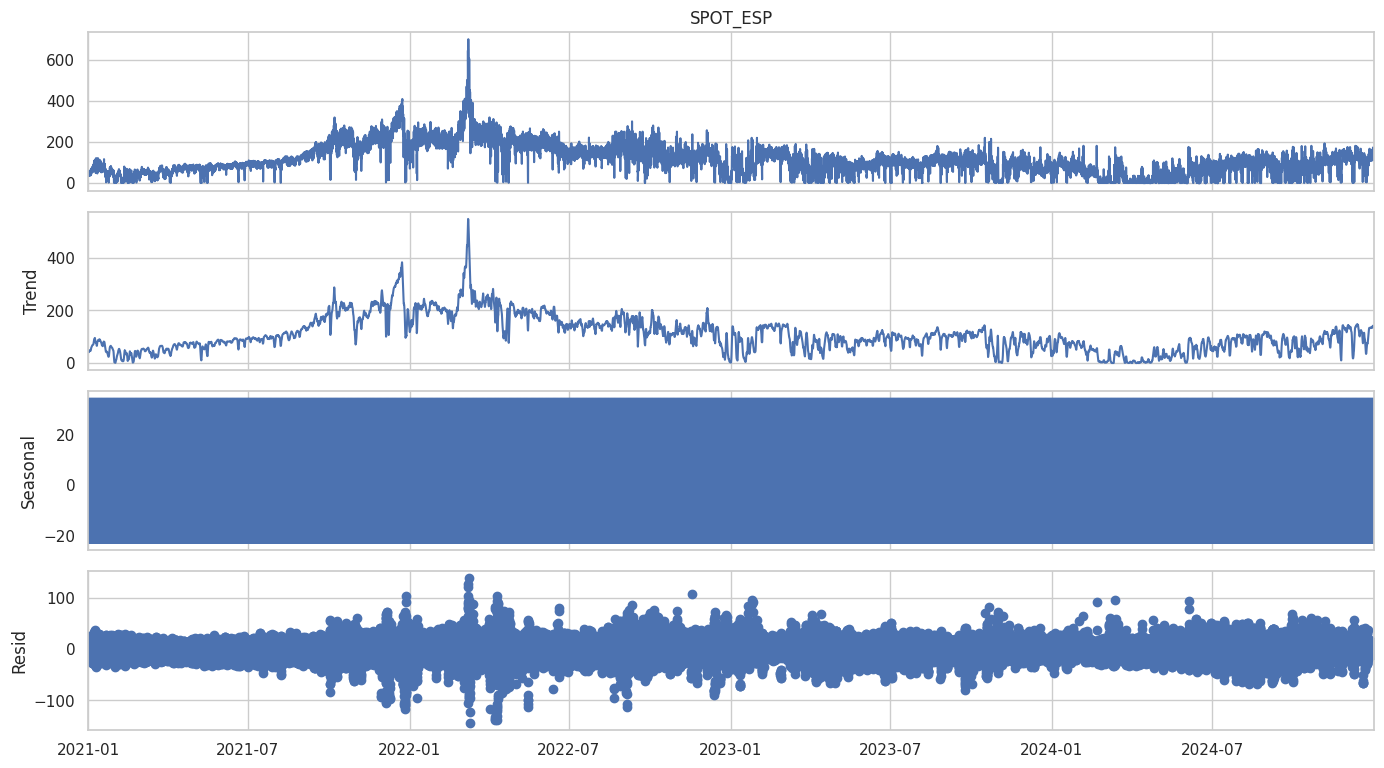

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie, model='additive', period=24)

fig = descomposicion.plot()
fig.set_size_inches(14, 8)
fig.suptitle("", fontsize=16, weight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

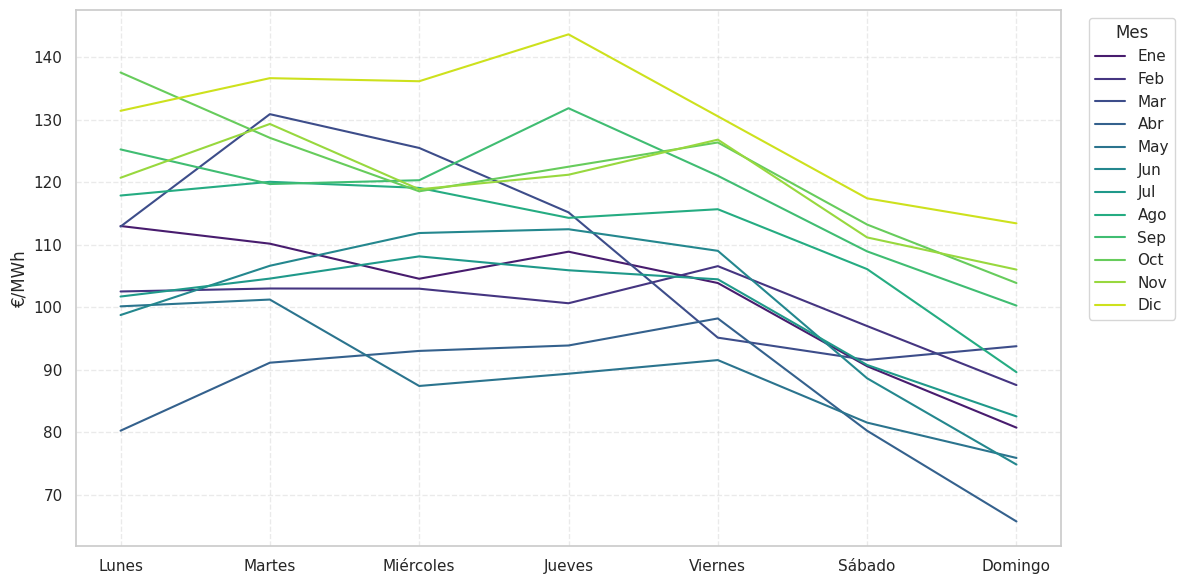

In [55]:
# 1. Aseguramos columnas necesarias
df['Mes'] = pd.to_datetime(df['date']).dt.month
df['Mes_nombre'] = df['Mes'].apply(lambda x: ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                                               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'][x-1])
df['DiaSemana'] = df['datetime'].dt.dayofweek
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
df['Dia_nombre'] = df['DiaSemana'].apply(lambda x: dias_semana[x])

# 2. Agrupamos por día de la semana y mes
df_semana_mes = df.groupby(['Dia_nombre', 'Mes_nombre'])['SPOT_ESP'].mean().reset_index()

# 3. Ordenar categorías para que se vean en orden
df_semana_mes['Dia_nombre'] = pd.Categorical(df_semana_mes['Dia_nombre'], categories=dias_semana, ordered=True)
df_semana_mes['Mes_nombre'] = pd.Categorical(df_semana_mes['Mes_nombre'], categories=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
], ordered=True)

# 4. Gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_semana_mes, x='Dia_nombre', y='SPOT_ESP', hue='Mes_nombre', palette='viridis')
plt.title("", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("€/MWh")
plt.legend(title="Mes", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [56]:
df['Año'] = df['datetime'].dt.year
df.groupby('Año')['SPOT_ESP'].mean()

Año
2021    111.926103
2022    167.482156
2023     87.075832
2024     63.046980
Name: SPOT_ESP, dtype: float64

In [57]:
df.groupby('Año')['SPOT_ESP'].std()

Año
2021    74.704781
2022    69.463362
2023    41.367865
2024    45.924632
Name: SPOT_ESP, dtype: float64

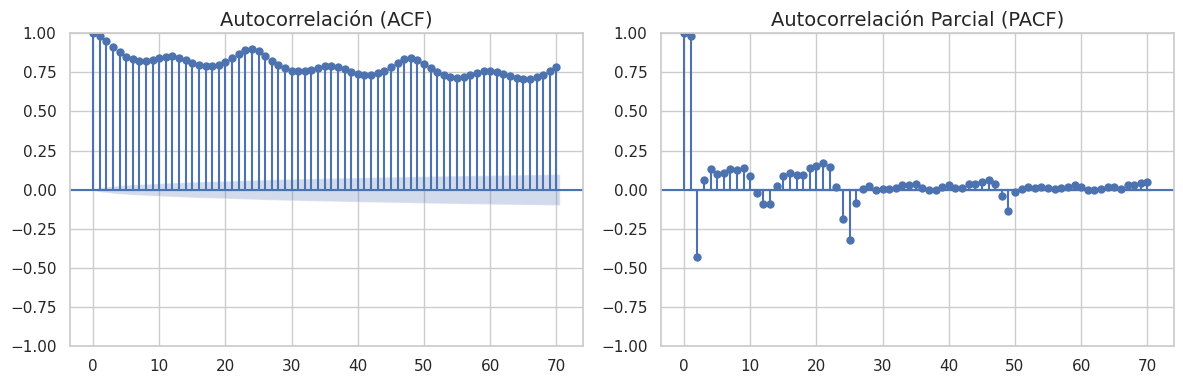

In [58]:
# 1. Asegurar que 'datetime' esté como índice con frecuencia horaria
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby('datetime', as_index=False).mean(numeric_only=True)
serie = df.set_index('datetime')['SPOT_ESP'].asfreq('h')

# 2. Eliminar valores NaN si los hubiera
serie = serie.dropna()

# 3. Graficar ACF y PACF con más separación
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # más ancho
plot_acf(serie, ax=axes[0], lags=70)
axes[0].set_title('Autocorrelación (ACF)', fontsize=14)

plot_pacf(serie, ax=axes[1], lags=70, method='ywm')
axes[1].set_title('Autocorrelación Parcial (PACF)', fontsize=14,)

plt.subplots_adjust(wspace=0.3)  # ← espacio horizontal entre gráficos
plt.tight_layout()
plt.show()

## Correlaciones

### Por día

In [59]:
df = df.drop(columns=['HoraDia'])

In [60]:
df['date'] = pd.to_datetime(df['datetime']).dt.date

# 2. Agrupar por día y calcular la media de todas las columnas numéricas
df_dia = df.groupby('date').mean(numeric_only=True)

# 3. Calcular la matriz de correlación
corr = df_dia.corr()

# 4. Extraer pares únicos de variables (sin duplicados ni diagonal)
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_pairs = corr.where(mask).stack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# 5. Filtrar correlaciones fuertes (positivas o negativas)
threshold = 0.75
corr_fuertes = corr_pairs[corr_pairs['Correlación'].abs() > threshold]

# 6. Ordenar por valor de la correlación (de negativo fuerte a positivo fuerte)
corr_fuertes = corr_fuertes.sort_values(by='Correlación', ascending=True)

# 7. Mostrar tabla
print(corr_fuertes)

                        Variable 1                    Variable 2  Correlación
41                            hour                   HoraTrabajo    -1.000000
522              Hidráulica no UGH                Hidráulica UGH     0.801558
366            Exportación Francia           Importación Francia     0.808457
284    Generación + Bombeo + Cable  Generación + Interconexiones     0.808467
294    Generación + Bombeo + Cable            Demanda Peninsular     0.815508
1166                           Mes                      Estacion     0.831236
236                     Hidráulica             Hidráulica no UGH     0.847387
1088                       SPOT_FR                          PVPC     0.863844
743            Importación Francia             Importación Total     0.868585
1121                     PrecioGas                          PVPC     0.875510
631                        Biomasa              Otras renovables     0.879694
1100                      SPOT_POR                          PVPC

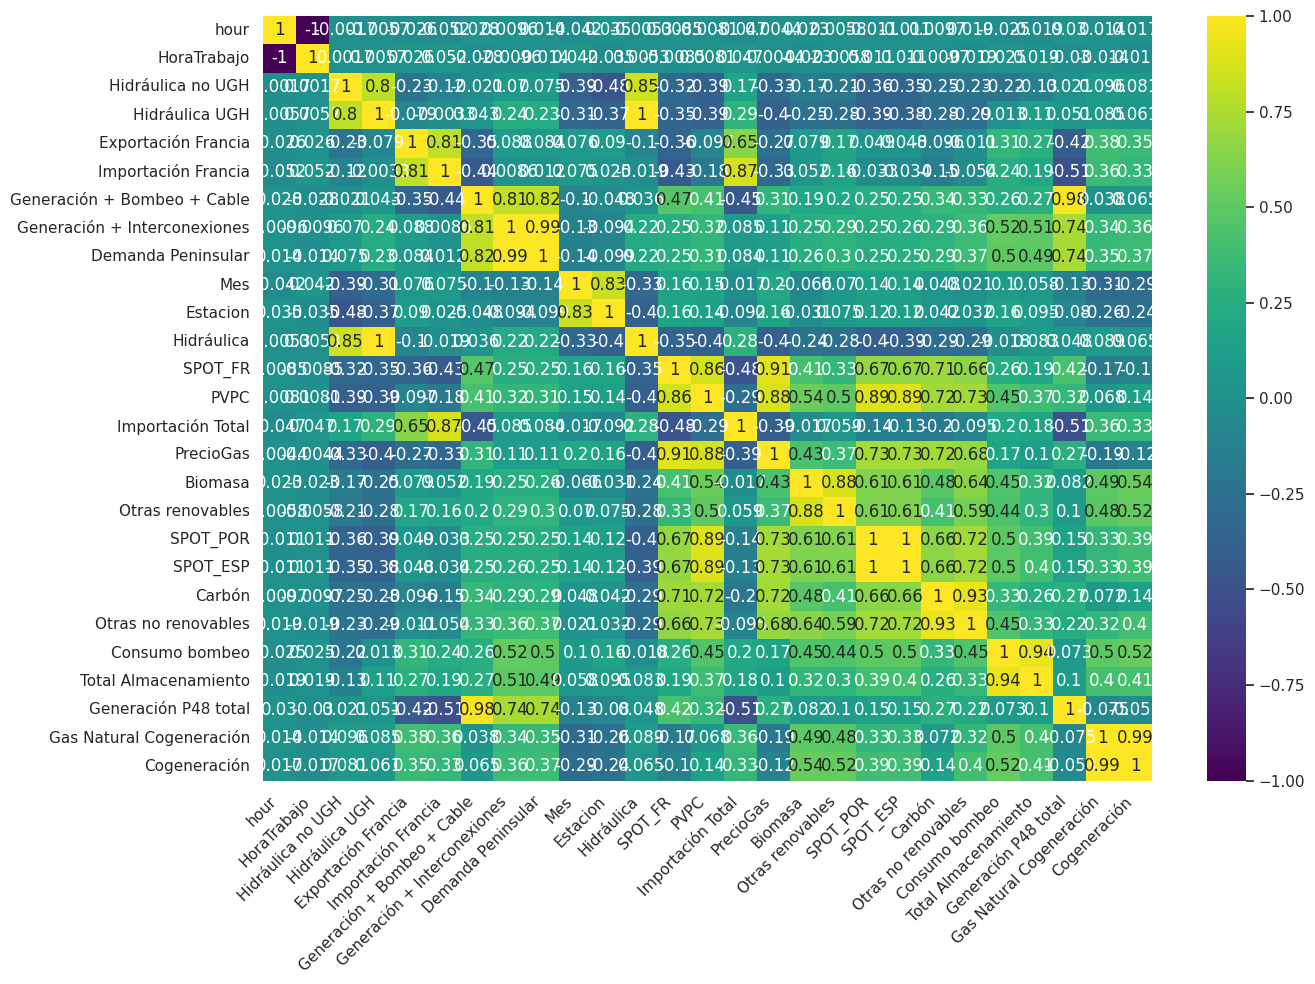

In [61]:
vars_interes = pd.unique(corr_fuertes[['Variable 1', 'Variable 2']].values.ravel())

# Submatriz con esas variables
sub_corr = corr.loc[vars_interes, vars_interes]

# Dibujar heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(sub_corr, annot=True, cmap="viridis", center=0)
plt.title("", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
df['date'] = pd.to_datetime(df['datetime']).dt.date

# 2. Agrupar por día y calcular la media de todas las columnas numéricas
df_dia = df.groupby('date').mean(numeric_only=True)

# 3. Calcular la matriz de correlación
corr = df_dia.corr()

# 4. Extraer pares únicos de variables (sin duplicados ni diagonal)
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_pairs = corr.where(mask).stack().reset_index()
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# 5. Filtrar correlaciones fuertes (positivas o negativas)
threshold = 0.75
corr_fuertes = corr_pairs[corr_pairs['Correlación'].abs() > threshold]

# 6. Ordenar por valor de la correlación (de negativo fuerte a positivo fuerte)
corr_fuertes = corr_fuertes.sort_values(by='Correlación', ascending=True)

# 7. Mostrar tabla
print(corr_fuertes)

                        Variable 1                    Variable 2  Correlación
41                            hour                   HoraTrabajo    -1.000000
522              Hidráulica no UGH                Hidráulica UGH     0.801558
366            Exportación Francia           Importación Francia     0.808457
284    Generación + Bombeo + Cable  Generación + Interconexiones     0.808467
294    Generación + Bombeo + Cable            Demanda Peninsular     0.815508
1166                           Mes                      Estacion     0.831236
236                     Hidráulica             Hidráulica no UGH     0.847387
1088                       SPOT_FR                          PVPC     0.863844
743            Importación Francia             Importación Total     0.868585
1121                     PrecioGas                          PVPC     0.875510
631                        Biomasa              Otras renovables     0.879694
1100                      SPOT_POR                          PVPC

In [63]:
# 5. Filtrar correlaciones fuertes (positivas o negativas)
threshold = 0.70
corr_fuertes = corr_pairs[corr_pairs['Correlación'].abs() > threshold]

# 6. Ordenar por valor de la correlación
corr_fuertes = corr_fuertes.sort_values(by='Correlación', ascending=True)

# 7. Mostrar tabla
print(corr_fuertes)

                        Variable 1                    Variable 2  Correlación
41                            hour                   HoraTrabajo    -1.000000
886                         Carbón                       SPOT_FR     0.706785
605                Ciclo combinado                          PVPC     0.717239
1109                      SPOT_POR           Otras no renovables     0.719362
889                         Carbón                     PrecioGas     0.720065
1084                      SPOT_ESP           Otras no renovables     0.721250
890                         Carbón                          PVPC     0.723876
1139                          PVPC           Otras no renovables     0.728222
1074                      SPOT_ESP                     PrecioGas     0.728970
1059                        Eólica                        GenCO2     0.730683
1099                      SPOT_POR                     PrecioGas     0.730699
560           Generación P48 total            Demanda Peninsular

### Por mes


In [64]:
# Crear columnas de año y mes
df['Año'] = pd.to_datetime(df['datetime']).dt.year
df['Mes'] = pd.to_datetime(df['datetime']).dt.month

# Agrupación mensual: media de cada variable por mes
df_mes = df.groupby(['Año', 'Mes']).mean(numeric_only=True)

In [65]:
# Matriz de correlación mensual
corr_mes = df_mes.corr()
# Extraer pares únicos
mask = np.triu(np.ones(corr_mes.shape), k=1).astype(bool)
corr_pairs_mes = corr_mes.where(mask).stack().reset_index()
corr_pairs_mes.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtro por correlación fuerte
threshold = 0.70
corr_fuertes_mes = corr_pairs_mes[corr_pairs_mes['Correlación'].abs() > threshold]

# Ordenar para análisis
corr_fuertes_mes = corr_fuertes_mes.sort_values(by='Correlación', ascending=True)

# Mostrar tabla
print(corr_fuertes_mes)

                        Variable 1                    Variable 2  Correlación
41                            hour                   HoraTrabajo    -1.000000
71              Turbinación bombeo                Consumo bombeo    -0.938118
73              Turbinación bombeo          Total Almacenamiento    -0.839796
1000                        Eólica                   tmed_hourly    -0.780362
767                  Solar térmica                        Eólica    -0.751569
180             Solar fotovoltaica         Exportación Marruecos    -0.705287
743                         Biogás                      SPOT_ESP     0.700340
817                Enlace Baleares                      SPOT_POR     0.703500
1003                      SPOT_ESP                       SPOT_FR     0.704294
1015                       SPOT_FR                      SPOT_POR     0.705259
827                Enlace Baleares           Otras no renovables     0.708720
815                Enlace Baleares                      SPOT_ESP

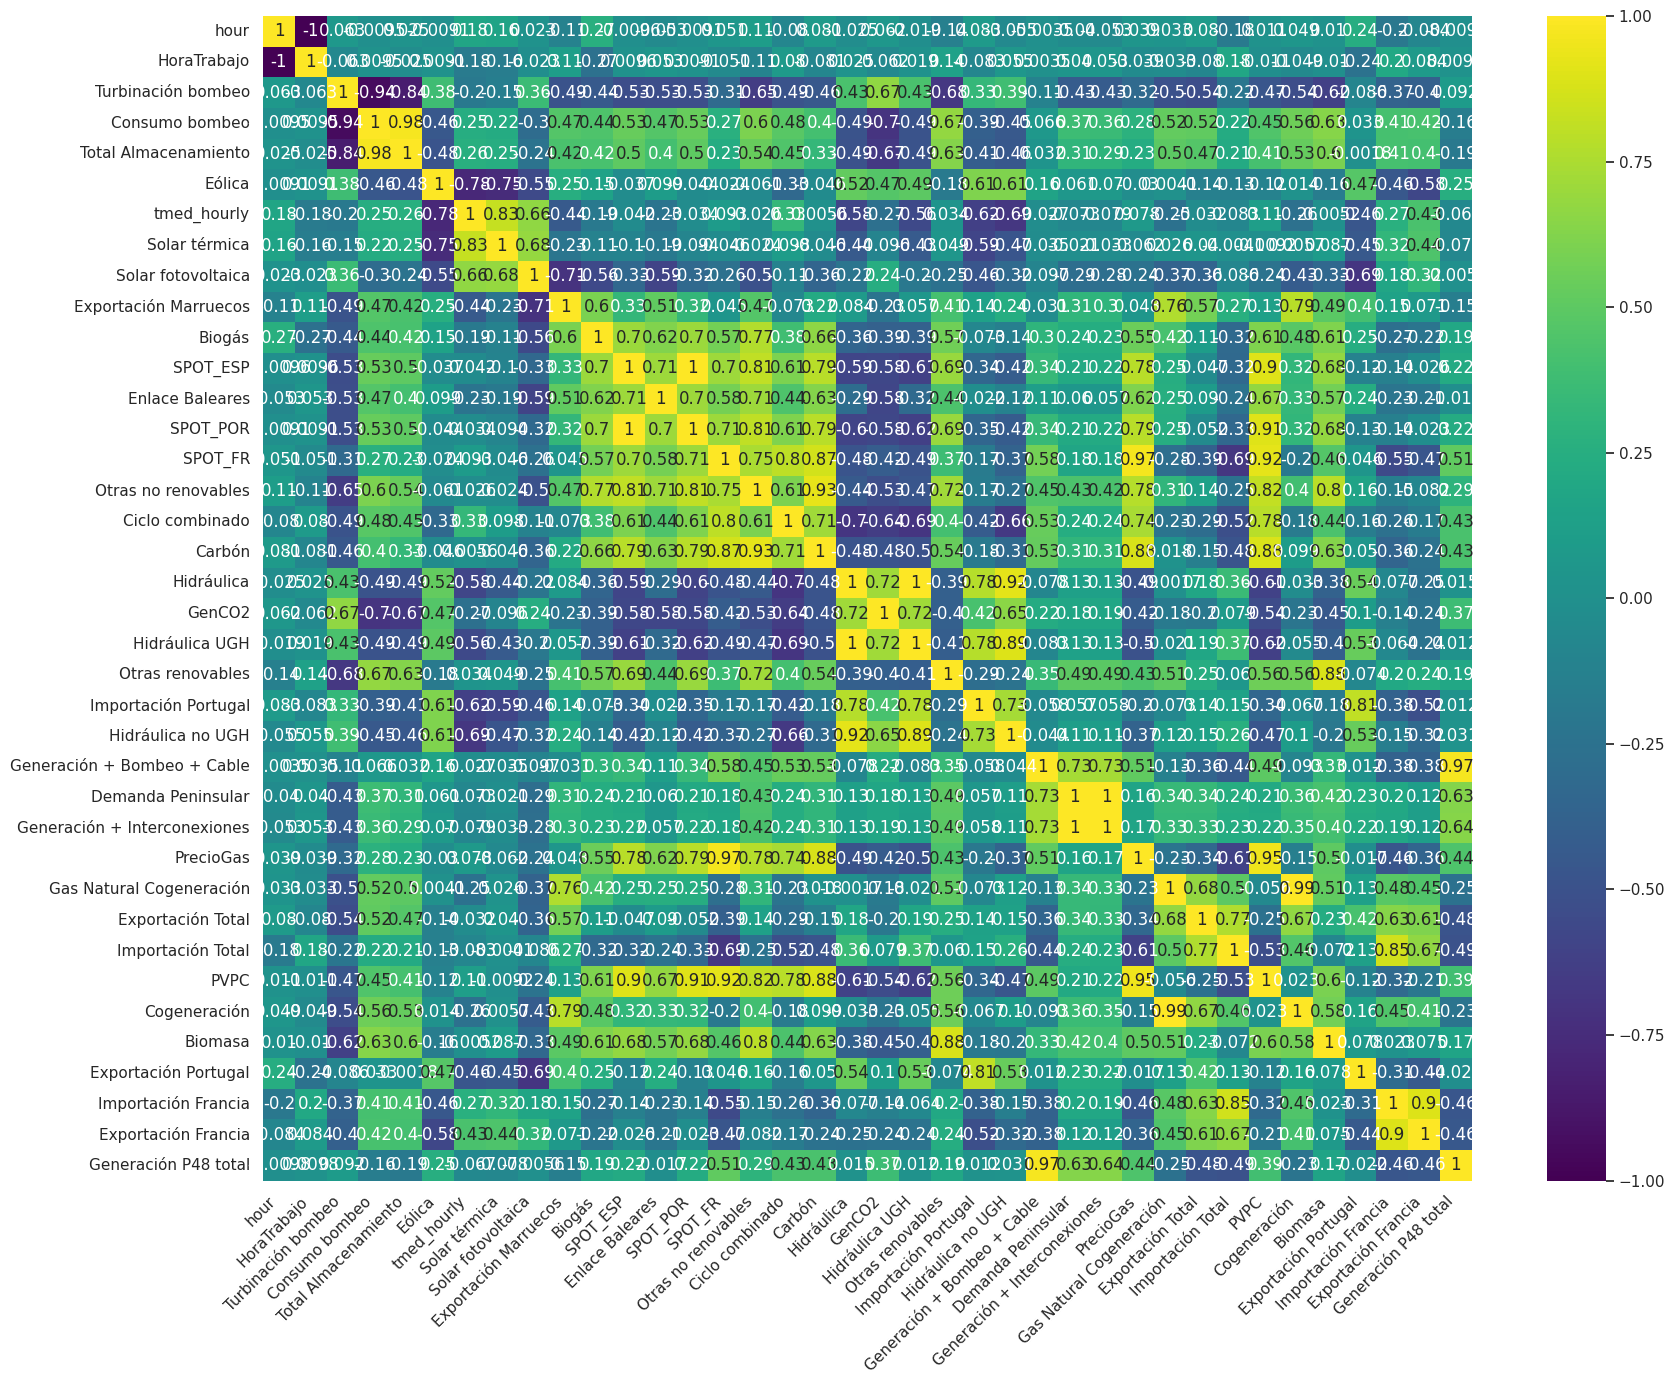

In [66]:
# Extraer variables implicadas
vars_interes_mes = pd.unique(corr_fuertes_mes[['Variable 1', 'Variable 2']].values.ravel())

# Submatriz
sub_corr_mes = corr_mes.loc[vars_interes_mes, vars_interes_mes]

# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))
sns.heatmap(sub_corr_mes, annot=True, cmap="viridis", center=0)
plt.title("", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Por año

In [67]:
# Agrupar por año y calcular la media de todas las variables numéricas
df['Año'] = pd.to_datetime(df['datetime']).dt.year
df_anual = df.groupby('Año').mean(numeric_only=True)

In [68]:
corr_anual = df_anual.corr()

In [69]:
import numpy as np

# Extraer pares únicos (sin duplicados ni diagonal)
mask = np.triu(np.ones(corr_anual.shape), k=1).astype(bool)
corr_pairs_anual = corr_anual.where(mask).stack().reset_index()
corr_pairs_anual.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar correlaciones fuertes
threshold = 0.70
corr_fuertes_anual = corr_pairs_anual[corr_pairs_anual['Correlación'].abs() > threshold]

# Ordenar de menor a mayor
corr_fuertes_anual = corr_fuertes_anual.sort_values(by='Correlación', ascending=True)

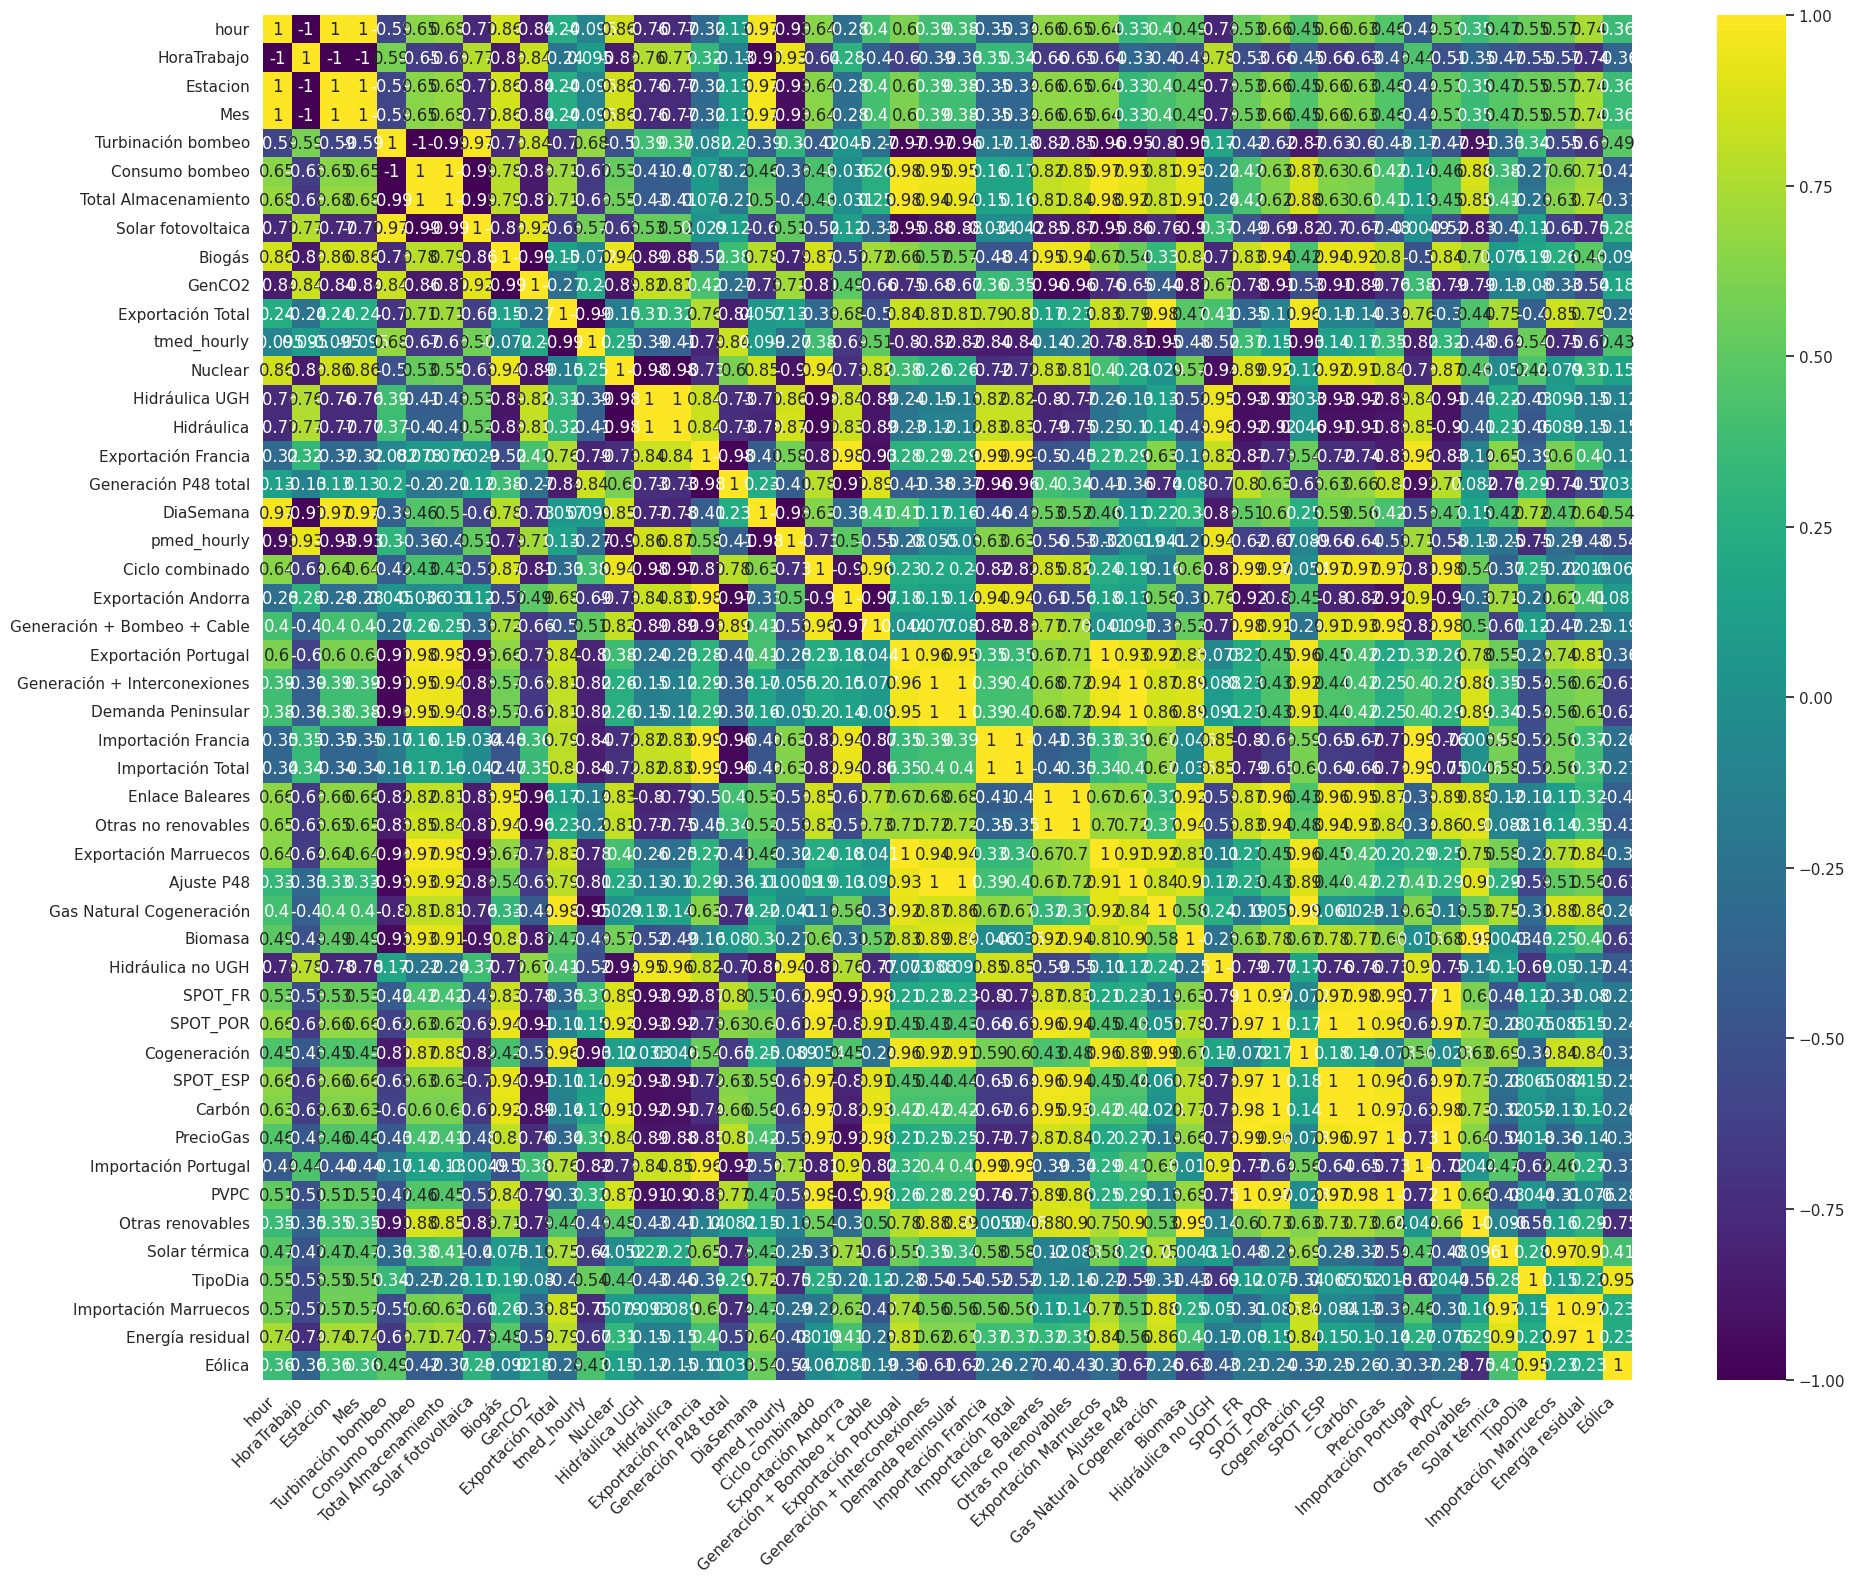

In [70]:
vars_interes_anual = pd.unique(corr_fuertes_anual[['Variable 1', 'Variable 2']].values.ravel())

# Submatriz con esas variables
sub_corr_anual = corr_anual.loc[vars_interes_anual, vars_interes_anual]

# Dibujar heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(sub_corr_anual, annot=True, cmap="viridis", center=0)
plt.title("", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [71]:
# prompt: print(corr_fuertes_anual[corr_fuertes_anual['Correlación'].abs() <= 0.95]) ver todas las filas

print(corr_fuertes_anual[corr_fuertes_anual['Correlación'].abs() <= 0.95].to_string())


                        Variable 1                    Variable 2  Correlación
422       Gas Natural Cogeneración                   tmed_hourly    -0.949414
193             Solar fotovoltaica          Exportación Portugal    -0.949056
60              Turbinación bombeo                       Biomasa    -0.945973
146                        Nuclear             Hidráulica no UGH    -0.936374
884                 Hidráulica UGH                       SPOT_FR    -0.934140
1120                           Mes                   pmed_hourly    -0.930321
1123                      Estacion                   pmed_hourly    -0.930321
45                            hour                   pmed_hourly    -0.930321
885                 Hidráulica UGH                      SPOT_POR    -0.929363
495                   Cogeneración                   tmed_hourly    -0.927926
268    Generación + Bombeo + Cable           Exportación Francia    -0.926273
883                 Hidráulica UGH                      SPOT_ESP

# Modelos de predicción

## Análisis de regresión múltiple

Todas las variables

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [76]:
X

hour  Turbinación bombeo  Exportación Andorra  Nuclear  \
0       0.0               86.80                -40.0  7106.10   
1       1.0                0.00                -37.0  7106.10   
2       2.0                0.00                -35.0  7106.10   
3       3.0                0.00                -34.0  7106.10   
4       4.0                0.00                -34.0  7105.10   
...     ...                 ...                  ...      ...   
35058  18.0             1158.40                -49.0  7089.00   
35059  19.0              705.05                -49.0  7089.00   
35060  20.0              192.05                -43.0  7089.00   
35061  21.0               17.50                -63.0  7089.00   
35062  22.0               17.50                -14.0  1772.25   

       Solar fotovoltaica  Hidráulica  Generación + Bombeo + Cable  \
0                   1.100     5092.90                    25218.400   
1                  10.700     4075.00                    24264.800   
2                   0.000     3468.00                    22848.700   
3                   0.000     3306.40                    22629.100   
4                   0.000     2988.60                    22540.800   
...                   ...         ...                          ...   
35058              12.300     7021.35                    29588.800   
35059               1.300     5843.45                    28984.700   
35060               1.400     4714.45                    26906.000   
35061               0.800     3192.60                    24733.225   
35062               0.175      657.05                     5875.825   

       Exportación Marruecos  Exportación Francia  Gas Natural Cogeneración  \
0                        0.0             -2463.40                  2091.300   
1                        0.0             -3561.00                  2080.400   
2                        0.0             -3561.00                  2074.200   
3                        0.0             -3746.00                  2071.900   
4                        0.0             -3746.00                  2073.400   
...                      ...                  ...                       ...   
35058                 -220.0              -185.00                  1718.000   
35059                 -190.0              -185.00                  1701.800   
35060                    0.0              -185.00                  1695.700   
35061                    0.0               -46.25                  1678.200   
35062                    0.0              -130.50                   412.575   

       Importación Portugal  Cogeneración  Hidráulica no UGH  \
0                   615.100        2175.2             964.30   
1                   482.300        2164.3             938.70   
2                   600.000        2158.1             930.80   
3                   193.600        2155.8             857.40   
4                   155.200        2157.3             854.30   
...                     ...           ...                ...   
35058               326.525        1762.1             641.30   
35059               252.875        1742.7             637.40   
35060               262.400        1736.6             629.70   
35061                69.950        1719.1             608.20   
35062               100.250         422.8             150.85   

       Generación P48 total  Ciclo combinado  Biomasa  Exportación Portugal  \
0                 26920.700         2815.700   454.90               -333.20   
1                 25866.900         2555.200   456.70               -374.00   
2                 25203.900         2289.300   464.60               -902.20   
3                 24899.200         1989.600   468.60              -1216.70   
4                 24735.800         1826.000   469.00              -1274.40   
...                     ...              ...      ...                   ...   
35058             30400.550        10027.800   337.50              -1729.15   
35059             29259.700        

In [77]:
# 1. Eliminar columnas no numéricas
X = df.drop(columns=['SPOT_ESP', 'datetime', 'date'], errors='ignore')  # por si existe también 'date'
y = df['SPOT_ESP']

# 2. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Ajustar el modelo
reg = LinearRegression().fit(X_train, y_train)

# 4. Predicciones
y_pred = reg.predict(X_test)

# 5. Evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = reg.score(X_train, y_train)

# 6. Resultados
print("📉 Error cuadrático medio (MSE):", round(mse, 2))
print("📈 Coeficiente de determinación (R²):", round(r2, 4))
print("📊 Sesgo (intercepto):", reg.intercept_)

# Mostrar coeficientes con sus nombres
for name, coef in zip(X.columns, reg.coef_):
    print(f"{name}: {coef:.4f}")

📉 Error cuadrático medio (MSE): 32.46
📈 Coeficiente de determinación (R²): 0.9953
📊 Sesgo (intercepto): -1730.5757810358677
hour: -0.0196
Turbinación bombeo: 0.0005
Exportación Andorra: -0.0109
Nuclear: 0.0091
Solar fotovoltaica: 0.0093
Hidráulica: 0.0058
Generación + Bombeo + Cable: 0.0216
Exportación Marruecos: 0.0002
Exportación Francia: 0.0002
Gas Natural Cogeneración: 0.0091
Importación Portugal: 0.0007
Cogeneración: 0.0010
Hidráulica no UGH: 0.0024
Generación P48 total: -0.0182
Ciclo combinado: 0.0092
Biomasa: 0.0100
Exportación Portugal: -0.0003
Exportación Total: 0.0127
Generación + Interconexiones: -0.0122
Importación Francia: -0.0003
Biogás: 0.0496
Solar térmica: 0.0085
Importación Total: 0.0130
Enlace Baleares: -0.0029
Carbón: 0.0003
Hidráulica UGH: 0.0034
Importación Marruecos: 0.0007
Consumo bombeo: -0.0167
Demanda Peninsular: -0.0005
Total Almacenamiento: 0.0088
Energía residual: -0.0056
Ajuste P48: -0.0209
Otras renovables: 0.0040
Eólica: 0.0094
SPOT_FR: 0.0045
SPOT_POR:

In [237]:
# 1. Eliminar variable objetivo del conjunto explicativo
X = df.drop(columns=['SPOT_ESP'])
y = df['SPOT_ESP']

# 2. Convertir variables categóricas a dummies (evita multicolinealidad con drop_first=True)
X = pd.get_dummies(X, drop_first=True)

# 3. Eliminar columnas no numéricas si queda alguna
X = X.select_dtypes(include=['number'])

# 4. Asegurar que no hay NaNs
X = X.dropna()
y = y.loc[X.index]

# 5. Añadir constante
X_const = sm.add_constant(X)

# 6. Ajustar modelo
modelo = sm.OLS(y, X_const).fit()

# 7. Mostrar resumen
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:               SPOT_ESP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.503e+05
Date:                Mon, 02 Jun 2025   Prob (F-statistic):               0.00
Time:                        16:27:52   Log-Likelihood:            -1.0653e+05
No. Observations:               35063   AIC:                         2.131e+05
Df Residuals:                   35016   BIC:                         2.135e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [258]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out=0.05,
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)

        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Agregado {best_feature} con p-valor {best_pval:.6}')

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()

        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f'Removido {worst_feature} con p-valor {worst_pval:.6}')

        if not changed:
            break

    return included

In [259]:
selected_vars = stepwise_selection(X.drop(columns=['datetime', 'fecha', 'fecha_num'], errors='ignore'), y)
print("Variables seleccionadas:", selected_vars)

Agregado Cogeneración con p-valor 0.0
Agregado Consumo bombeo con p-valor 0.0
Agregado Biogás con p-valor 0.0
Agregado Otras renovables con p-valor 0.0
Agregado Gas Natural Cogeneración con p-valor 0.0
Agregado SPOT_FR con p-valor 0.0
Agregado SPOT_POR con p-valor 0.0
Agregado Solar térmica con p-valor 4.86217e-142
Removido Biogás con p-valor 0.651905
Agregado PVPC con p-valor 2.28712e-128
Removido Gas Natural Cogeneración con p-valor 0.087045
Agregado Importación Portugal con p-valor 4.51549e-48
Agregado Enlace Baleares con p-valor 6.3686e-59
Removido SPOT_FR con p-valor 0.838256
Agregado Exportación Portugal con p-valor 3.55131e-25
Agregado Ciclo combinado con p-valor 3.07283e-18
Agregado Nuclear con p-valor 2.58213e-15
Agregado Exportación Andorra con p-valor 1.37864e-14
Agregado PrecioGas con p-valor 5.51807e-13
Agregado SPOT_FR con p-valor 2.96332e-16
Agregado Generación P48 total con p-valor 6.84581e-16
Agregado Eólica con p-valor 1.55427e-10
Agregado hour con p-valor 5.7609e-06


✅ Lo que observamos:
	1.	R² ajustado ≈ 0.995 → El modelo explica muy bien la variabilidad de SPOT_ESP (pero ojo con sobreajuste).
	2.	Muchas variables son estadísticamente significativas (P>|t| < 0.05).
	3.	Problema de multicolinealidad: aparece esta advertencia:
“The smallest eigenvalue is 1.29e-18. This might indicate that there are strong multicollinearity problems.”

Eso indica que algunas variables están muy correlacionadas entre sí → redundancia.

In [238]:
!pip install mlxtend

In [239]:
# importing the models

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

In [268]:
lreg = LinearRegression()
sfs1 = sfs(lreg, k_features=10, forward=True, verbose=2, scoring='neg_mean_squared_error')

X = df.drop(columns=['SPOT_ESP', 'Año', 'Mes', 'date', 'datetime'])
y = df['SPOT_ESP']

sfs1 = sfs1.fit(X, y);

feat_names = list(sfs1.k_feature_names_)
print(feat_names)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    2.2s finished

[2025-06-02 17:43:21] Features: 1/10 -- score: -29.639315620453722[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.9s finished

[2025-06-02 17:43:23] Features: 2/10 -- score: -28.897649138378295[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    1.9s finished

[2025-06-02 17:43:25] Features: 3/10 -- score: -28.598026307063826[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.5s finished

[2025-06-02 17:43:26] Features: 4/10 -- score: -28.52129756378029[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    1.6s finished

[2025-06-02 17:43:28] Features: 5/10 -- score: -28.267140350043285[Parallel(n

['Solar fotovoltaica', 'Importación Portugal', 'Solar térmica', 'Enlace Baleares', 'Importación Marruecos', 'Consumo bombeo', 'Total Almacenamiento', 'Otras renovables', 'Eólica', 'SPOT_POR']


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    4.1s finished

[2025-06-02 17:43:57] Features: 10/10 -- score: -27.988666863088195

In [269]:
import statsmodels.api as sm
import pandas as pd

# Definir X e y (asegúrate de eliminar variables no numéricas como datetime)
X = df.drop(columns=['SPOT_ESP', 'Año', 'Mes', 'date', 'datetime'])
y = df['SPOT_ESP']

# Iniciar con variables vacías
variables_disponibles = list(X.columns)
variables_seleccionadas = []
mejor_aic = float('inf')
mejor_modelo = None

while True:
    aic_dict = {}
    for var in variables_disponibles:
        # Probar añadir cada variable candidata
        vars_probar = variables_seleccionadas + [var]
        X_sel = sm.add_constant(X[vars_probar])
        modelo = sm.OLS(y, X_sel).fit()
        aic_dict[var] = modelo.aic

    # Elegir la variable que más reduce el AIC
    mejor_var = min(aic_dict, key=aic_dict.get)
    if aic_dict[mejor_var] < mejor_aic:
        mejor_aic = aic_dict[mejor_var]
        variables_seleccionadas.append(mejor_var)
        variables_disponibles.remove(mejor_var)
        mejor_modelo = sm.OLS(y, sm.add_constant(X[variables_seleccionadas])).fit()
        print(f"Añadida: {mejor_var} | AIC: {mejor_aic:.2f}")
    else:
        print("No mejora AIC. Selección finalizada.")
        break

# Mostrar resultado final
print("\nVariables seleccionadas:")
print(variables_seleccionadas)
print(mejor_modelo.summary())

Añadida: SPOT_POR | AIC: 218278.40
Añadida: Consumo bombeo | AIC: 216550.00
Añadida: Solar térmica | AIC: 216011.14
Añadida: PVPC | AIC: 215376.92
Añadida: Cogeneración | AIC: 215013.92
Añadida: Enlace Baleares | AIC: 214805.22
Añadida: Importación Portugal | AIC: 214553.44
Añadida: Exportación Portugal | AIC: 214436.31
Añadida: Ciclo combinado | AIC: 214365.25
Añadida: Otras renovables | AIC: 214315.62
Añadida: Nuclear | AIC: 214255.03
Añadida: Exportación Andorra | AIC: 214197.75
Añadida: PrecioGas | AIC: 214147.71
Añadida: SPOT_FR | AIC: 214082.86
Añadida: Generación P48 total | AIC: 214019.65
Añadida: Eólica | AIC: 213980.67
Añadida: hour | AIC: 213962.09
Añadida: Biogás | AIC: 213944.93
Añadida: Importación Marruecos | AIC: 213933.69
Añadida: Exportación Total | AIC: 213922.13
Añadida: Hidráulica no UGH | AIC: 213914.97
Añadida: Gas Natural Cogeneración | AIC: 213908.94
Añadida: tmed_hourly | AIC: 213903.71
Añadida: Generación + Bombeo + Cable | AIC: 213897.76
Añadida: Ajuste P48 

In [261]:
# Eliminar columnas tipo datetime
X = X.select_dtypes(exclude=['datetime', 'datetime64[ns]'])

In [270]:
import statsmodels.api as sm

# Eliminar variables no numéricas
X = df.drop(columns=['SPOT_ESP', 'date', 'datetime', 'Año', 'Mes'])  # ajusta si falta alguna
y = df['SPOT_ESP']

X_const = sm.add_constant(X)
modelo_completo = sm.OLS(y, X_const).fit()

print("📊 MÉTRICAS MODELO COMPLETO")
print(f"AIC: {modelo_completo.aic:.2f}")
print(f"BIC: {modelo_completo.bic:.2f}")
print(f"R² ajustado: {modelo_completo.rsquared_adj:.4f}")

📊 MÉTRICAS MODELO COMPLETO
AIC: 213473.76
BIC: 213854.68
R² ajustado: 0.9949


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

lreg = LinearRegression()

# Selección hacia adelante
sfs_forward = SFS(lreg,
                  k_features='best',
                  forward=True,
                  floating=False,
                  scoring='r2',
                  cv=5,
                  n_jobs=-1,
                  verbose=2)
sfs_forward.fit(X, y)

# Selección hacia atrás
sfs_backward = SFS(lreg,
                   k_features='best',
                   forward=False,
                   floating=False,
                   scoring='r2',
                   cv=5,
                   n_jobs=-1,
                   verbose=2)
sfs_backward.fit(X, y)

# Stepwise (floating forward selection)
sfs_stepwise = SFS(lreg,
                   k_features='best',
                   forward=True,
                   floating=True,
                   scoring='r2',
                   cv=5,
                   n_jobs=-1,
                   verbose=2)
sfs_stepwise.fit(X, y)

# Variables seleccionadas
print("Variables forward:", list(sfs_forward.k_feature_names_))
print("Variables backward:", list(sfs_backward.k_feature_names_))
print("Variables stepwise:", list(sfs_stepwise.k_feature_names_))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    7.8s finished

[2025-06-02 17:48:05] Features: 1/46 -- score: 0.9863022615401278[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.9s finished

[2025-06-02 17:48:07] Features: 2/46 -- score: 0.9867840159062087[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    2.0s finished

[2025-06-02 17:48:09] Features: 3/46 -- score: 0.9869828055548808[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    1.5s finished

[2025-06-02 17:48:10] Features: 4/46 -- score: 0.98712038417081[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_